In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 100

In [5]:
seed = 9295
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 0 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  VBKG0BIX_20_55_45
NN-MODEL FILENAME:  ./models/VBKG0BIX_20_55_45_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s     = borders
    
    indx = np.empty_like(value).astype(np.intp)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax().astype(np.intp)
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.intp)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-4  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 500   # target update frequency
MIN_MEMORY_CAP      = 200000

In [11]:
MAX_NO_OF_ITERATIONS = 50
MAX_NN_ITERATIONS    = 50000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  50


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action
    
    def get_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions = self.eval_net.forward(x).view(-1,N_ACTIONS).max(1)[1].data.numpy().astype(np.intp)
#         actions_value 
#         action = torch.max(actions_value, 1)[1].data.numpy()
#         action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return actions
    
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.6
C_POS_ABS_MIN = -2.6

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
print("HI_GRAIN = ", HI_GRAIN)

HI_GRAIN =  40


In [16]:
def mp_node_run(node_id, boundary, iteration, node_q_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################


    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s]
    ###############################################
    
    my_Q_TABLE = node_q_table

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((3%5 + 1)*0.1 + (iteration)*0.2) ,0.4,0.98)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            s = my_env.reset()
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state]

                 # take action
                s_, r, done, info = my_env.step(a)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN] = [exp_rec[:,i].min() for i in range(N_STATES)]

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN])



# # GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 1256.68 MiB, increment: 1036.10 MiB
Quantization TIME:  0.02 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table



ITERATION # 0
TOTAL EXPERIENCE GENERATED:   15558
SMALLEST TIMESTEP: 8
LARGEST  TIMESTEP: 61
TOTAL SERIAL TIMESTEPS:   15558
TOTAL PARALLEL TIMESTEPS: 61


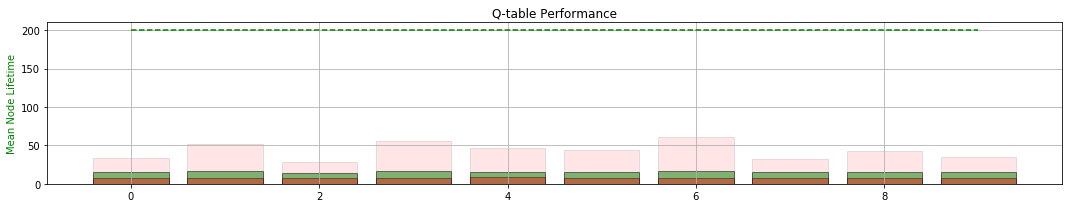

MEMORY COUNTER:  15558
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 624.241	LOSS : 600.516	LOSS : 635.032	LOSS : 588.245	LOSS : 610.574	LOSS : 573.134	LOSS : 594.320	LOSS : 550.615	LOSS : 542.194	LOSS : 550.035	LOSS : 568.529	LOSS : 555.182	LOSS : 549.828	LOSS : 541.816	LOSS : 538.100	LOSS : 515.535	LOSS : 524.628	LOSS : 527.777	LOSS : 504.086	LOSS : 517.717	
Validating... MEAN TIME:  9.36
LOSS : 513.627	LOSS : 526.816	LOSS : 518.406	LOSS : 506.994	LOSS : 522.741	LOSS : 523.741	LOSS : 520.820	LOSS : 538.378	LOSS : 517.404	LOSS : 523.031	LOSS : 523.345	LOSS : 515.600	LOSS : 513.155	LOSS : 539.857	LOSS : 523.693	LOSS : 520.879	LOSS : 529.485	LOSS : 510.819	LOSS : 529.133	LOSS : 507.206	
Validating... MEAN TIME:  9.435
LOSS : 519.688	LOSS : 508.388	LOSS : 506.261	LOSS : 526.036	LOSS : 517.465	LOSS : 516.637	LOSS : 493.167	LOSS : 497.846	LOSS : 493.711	LOSS : 495.402	LOSS : 503.808	LOSS : 494.979	LOSS : 484.297	LOSS : 498.251	LOSS : 502.740	LOSS : 509.095	LOSS : 501.9

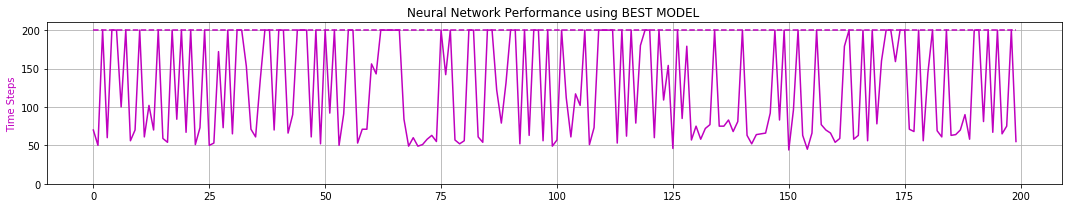

peak memory: 1322.88 MiB, increment: 1044.82 MiB
0 -max- [ 0.338  2.159  0.206  1.734]
0 -min- [-0.154 -1.207 -0.209 -2.916]

1 -max- [ 0.364  1.986  0.203  1.216]
1 -min- [-0.126 -0.943 -0.209 -2.766]

2 -max- [ 0.249  1.803  0.204  1.669]
2 -min- [-0.173 -1.027 -0.209 -2.749]

3 -max- [ 0.910  3.634  0.207  2.169]
3 -min- [-0.185 -1.331 -0.209 -3.350]

4 -max- [ 0.590  2.667  0.207  1.767]
4 -min- [-0.108 -0.981 -0.209 -2.742]

5 -max- [ 0.355  2.262  0.207  1.775]
5 -min- [-0.162 -1.120 -0.209 -2.747]

6 -max- [ 0.756  2.327  0.201  1.385]
6 -min- [-0.126 -0.976 -0.209 -3.012]

7 -max- [ 0.258  2.080  0.206  1.026]
7 -min- [-0.058 -0.627 -0.209 -2.751]

8 -max- [ 0.216  1.797  0.196  1.515]
8 -min- [-0.297 -1.496 -0.209 -2.726]

9 -max- [ 0.272  2.465  0.195  2.014]
9 -min- [-0.163 -1.167 -0.208 -2.961]

Quantization TIME:  0.02 minutes


ITERATION # 1
TOTAL EXPERIENCE GENERATED:   47823
SMALLEST TIMESTEP: 11
LARGEST  TIMESTEP: 188
TOTAL SERIAL TIMESTEPS:   63381
TOTAL PARALLEL TIME

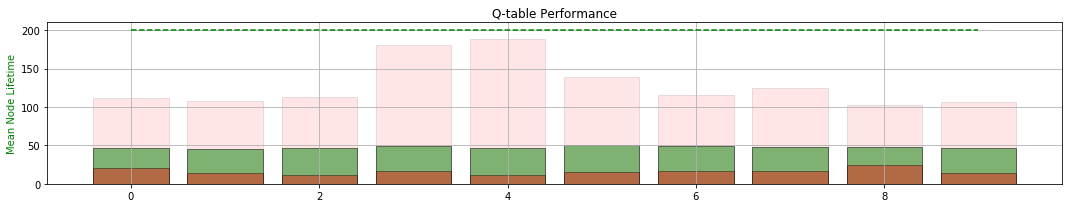

MEMORY COUNTER:  63381
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 289.009	LOSS : 271.297	LOSS : 295.045	LOSS : 284.393	LOSS : 288.652	LOSS : 307.844	LOSS : 277.297	LOSS : 282.145	LOSS : 289.538	LOSS : 268.505	LOSS : 262.334	LOSS : 286.981	LOSS : 271.280	LOSS : 280.763	LOSS : 251.217	LOSS : 288.956	LOSS : 262.239	LOSS : 282.844	LOSS : 271.564	LOSS : 283.147	
Validating... MEAN TIME:  65.325
LOSS : 277.713	LOSS : 263.142	LOSS : 282.062	LOSS : 266.904	LOSS : 281.644	LOSS : 248.488	LOSS : 270.549	LOSS : 269.929	LOSS : 258.492	LOSS : 262.935	LOSS : 265.677	LOSS : 279.141	LOSS : 271.917	LOSS : 261.641	LOSS : 275.056	LOSS : 249.167	LOSS : 263.765	LOSS : 262.969	LOSS : 272.542	LOSS : 264.137	
Validating... MEAN TIME:  79.89
LOSS : 271.207	LOSS : 267.545	LOSS : 271.686	LOSS : 261.958	LOSS : 260.238	LOSS : 267.168	LOSS : 261.934	LOSS : 261.224	LOSS : 256.325	LOSS : 261.342	LOSS : 271.096	LOSS : 258.679	LOSS : 281.784	LOSS : 252.155	LOSS : 252.611	LOSS : 254.359	LOSS : 242

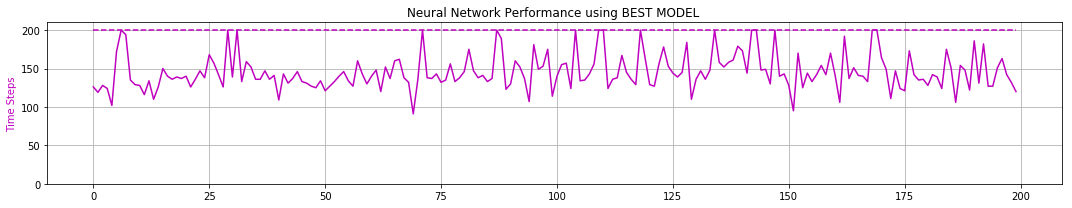

peak memory: 1404.11 MiB, increment: 1064.44 MiB
0 -max- [ 0.367  1.461  0.209  1.773]
0 -min- [-0.499 -1.158 -0.209 -1.359]

1 -max- [ 0.218  0.951  0.209  1.678]
1 -min- [-0.481 -1.129 -0.209 -1.423]

2 -max- [ 0.274  1.135  0.209  1.995]
2 -min- [-0.522 -1.286 -0.209 -1.410]

3 -max- [ 0.218  1.125  0.209  1.688]
3 -min- [-0.430 -1.113 -0.209 -1.207]

4 -max- [ 0.351  1.139  0.209  1.788]
4 -min- [-0.363 -1.029 -0.209 -1.769]

5 -max- [ 0.339  1.183  0.209  2.259]
5 -min- [-0.484 -1.396 -0.209 -1.555]

6 -max- [ 0.409  1.101  0.209  2.066]
6 -min- [-0.381 -1.209 -0.209 -1.697]

7 -max- [ 0.162  0.932  0.209  1.524]
7 -min- [-0.451 -1.072 -0.209 -1.417]

8 -max- [ 0.250  0.957  0.209  1.485]
8 -min- [-0.408 -1.156 -0.209 -1.339]

9 -max- [ 0.232  0.972  0.209  1.699]
9 -min- [-0.443 -1.157 -0.208 -1.819]

Quantization TIME:  0.01 minutes


ITERATION # 2
TOTAL EXPERIENCE GENERATED:   98600
SMALLEST TIMESTEP: 16
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   161981
TOTAL PARALLEL TIM

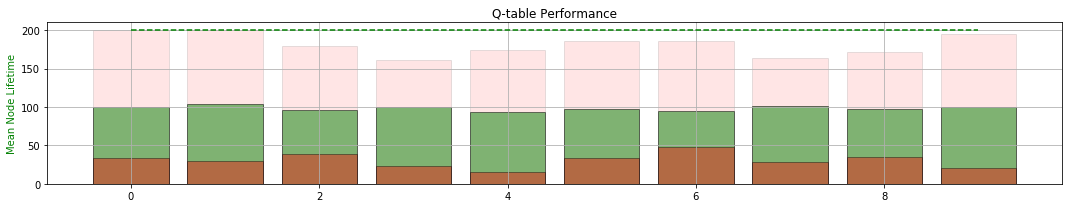

MEMORY COUNTER:  161981
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 162.345	LOSS : 168.982	LOSS : 163.004	LOSS : 159.471	LOSS : 181.736	LOSS : 184.430	LOSS : 166.413	LOSS : 163.050	LOSS : 162.376	LOSS : 177.679	LOSS : 159.233	LOSS : 163.597	LOSS : 151.754	LOSS : 153.731	LOSS : 152.891	LOSS : 163.295	LOSS : 162.442	LOSS : 156.538	LOSS : 161.459	LOSS : 154.136	
Validating... MEAN TIME:  130.54
LOSS : 157.523	LOSS : 169.121	LOSS : 159.614	LOSS : 158.025	LOSS : 152.978	LOSS : 155.175	LOSS : 167.488	LOSS : 166.059	LOSS : 169.894	LOSS : 177.229	LOSS : 150.254	LOSS : 154.283	LOSS : 163.048	LOSS : 167.650	LOSS : 163.669	LOSS : 157.631	LOSS : 152.897	LOSS : 159.704	LOSS : 165.986	LOSS : 161.029	
Validating... MEAN TIME:  136.37
LOSS : 161.683	LOSS : 147.174	LOSS : 166.263	LOSS : 164.921	LOSS : 163.665	LOSS : 163.669	LOSS : 156.822	LOSS : 153.818	LOSS : 149.493	LOSS : 165.971	LOSS : 160.617	LOSS : 150.621	LOSS : 164.210	LOSS : 161.068	LOSS : 175.458	LOSS : 161.995	LOSS : 1

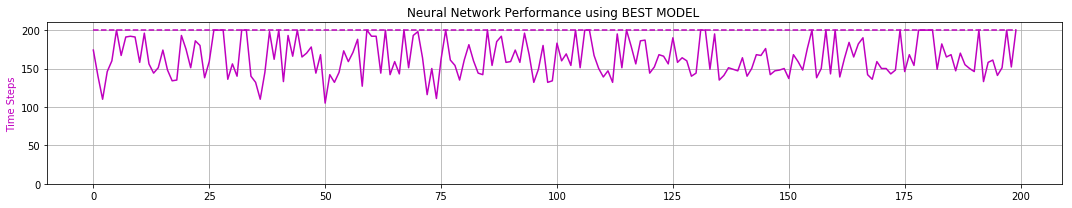

peak memory: 1403.87 MiB, increment: 978.96 MiB
0 -max- [ 0.553  1.160  0.209  1.113]
0 -min- [-2.380 -3.120 -0.209 -1.510]

1 -max- [ 0.547  1.201  0.209  1.130]
1 -min- [-2.371 -3.290 -0.209 -1.559]

2 -max- [ 0.573  1.069  0.208  1.075]
2 -min- [-2.383 -3.099 -0.209 -1.708]

3 -max- [ 0.542  0.955  0.206  1.105]
3 -min- [-2.383 -3.287 -0.209 -1.461]

4 -max- [ 0.591  1.271  0.208  1.077]
4 -min- [-2.386 -3.083 -0.209 -1.429]

5 -max- [ 0.615  0.961  0.209  1.392]
5 -min- [-2.387 -2.939 -0.209 -1.382]

6 -max- [ 0.516  0.958  0.208  1.013]
6 -min- [-2.369 -2.953 -0.209 -1.386]

7 -max- [ 0.548  0.906  0.206  1.128]
7 -min- [-2.395 -3.060 -0.209 -1.477]

8 -max- [ 0.688  1.154  0.209  1.055]
8 -min- [-2.397 -3.070 -0.209 -1.350]

9 -max- [ 0.687  1.144  0.208  1.115]
9 -min- [-2.385 -3.095 -0.209 -1.612]

Quantization TIME:  0.01 minutes


ITERATION # 3
TOTAL EXPERIENCE GENERATED:   124735
SMALLEST TIMESTEP: 96
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   286716
TOTAL PARALLEL TIM

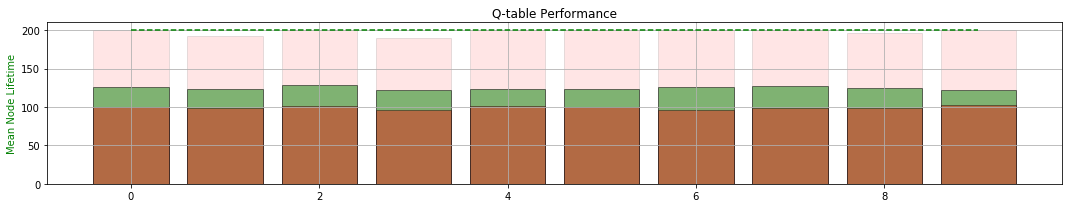

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 90.465	LOSS : 82.450	LOSS : 99.393	LOSS : 83.525	LOSS : 84.699	LOSS : 90.771	LOSS : 90.217	LOSS : 88.676	LOSS : 72.549	LOSS : 93.099	LOSS : 75.041	LOSS : 80.199	LOSS : 87.452	LOSS : 86.600	LOSS : 93.028	LOSS : 82.679	LOSS : 79.808	LOSS : 85.087	LOSS : 82.665	LOSS : 90.498	
Validating... MEAN TIME:  160.38
LOSS : 80.640	LOSS : 90.651	LOSS : 88.389	LOSS : 90.607	LOSS : 90.152	LOSS : 80.839	LOSS : 84.566	LOSS : 74.593	LOSS : 78.530	LOSS : 76.370	LOSS : 73.196	LOSS : 80.855	LOSS : 85.029	LOSS : 82.324	LOSS : 87.282	LOSS : 82.112	LOSS : 92.550	LOSS : 86.557	LOSS : 90.682	LOSS : 86.104	
Validating... MEAN TIME:  164.8
LOSS : 79.948	LOSS : 73.617	LOSS : 88.260	LOSS : 88.477	LOSS : 93.487	LOSS : 86.087	LOSS : 85.832	LOSS : 81.113	LOSS : 85.564	LOSS : 80.884	LOSS : 81.498	LOSS : 79.570	LOSS : 68.989	LOSS : 86.532	LOSS : 85.189	LOSS : 86.632	LOSS : 89.415	LOSS : 85.365	LOSS : 91.248	LOSS : 81.001	
Validati

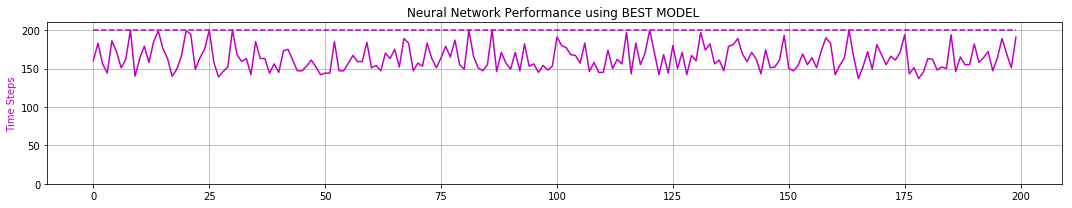

peak memory: 1407.43 MiB, increment: 978.81 MiB
0 -max- [ 0.149  0.596  0.050  0.641]
0 -min- [-2.190 -2.595 -0.209 -0.940]

1 -max- [ 0.145  0.626  0.047  0.795]
1 -min- [-2.257 -2.582 -0.209 -0.847]

2 -max- [ 0.186  0.620  0.048  0.653]
2 -min- [-2.379 -2.592 -0.209 -0.863]

3 -max- [ 0.147  0.575  0.048  0.657]
3 -min- [-2.181 -2.544 -0.209 -0.821]

4 -max- [ 0.159  0.627  0.046  0.922]
4 -min- [-2.297 -2.591 -0.209 -0.975]

5 -max- [ 0.166  0.594  0.048  0.677]
5 -min- [-2.297 -2.582 -0.209 -0.803]

6 -max- [ 0.169  0.560  0.049  0.904]
6 -min- [-2.204 -2.544 -0.209 -0.820]

7 -max- [ 0.186  0.601  0.049  0.673]
7 -min- [-2.286 -2.596 -0.209 -0.833]

8 -max- [ 0.171  0.439  0.049  0.642]
8 -min- [-2.289 -2.586 -0.209 -0.823]

9 -max- [ 0.130  0.630  0.050  0.637]
9 -min- [-2.214 -2.571 -0.209 -0.886]

Quantization TIME:  0.01 minutes


ITERATION # 4
TOTAL EXPERIENCE GENERATED:   127870
SMALLEST TIMESTEP: 106
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   414586
TOTAL PARALLEL TI

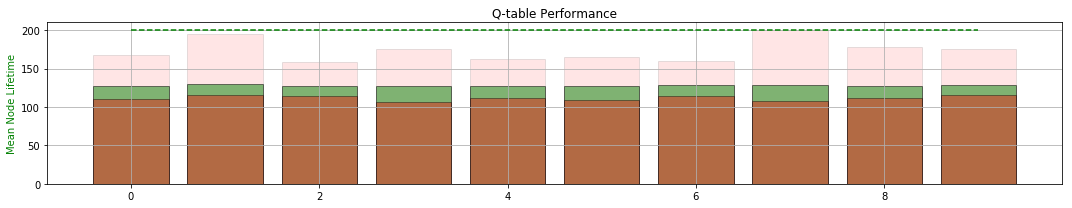

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 78.054	LOSS : 73.176	LOSS : 70.987	LOSS : 78.727	LOSS : 83.695	LOSS : 75.776	LOSS : 83.863	LOSS : 84.758	LOSS : 86.783	LOSS : 91.423	LOSS : 79.832	LOSS : 80.139	LOSS : 83.457	LOSS : 69.652	LOSS : 79.683	LOSS : 73.000	LOSS : 67.943	LOSS : 77.774	LOSS : 88.785	LOSS : 78.138	
Validating... MEAN TIME:  132.255
LOSS : 79.859	LOSS : 81.046	LOSS : 80.473	LOSS : 72.970	LOSS : 75.064	LOSS : 75.058	LOSS : 70.296	LOSS : 72.862	LOSS : 68.638	LOSS : 81.910	LOSS : 67.275	LOSS : 90.770	LOSS : 67.514	LOSS : 77.476	LOSS : 79.912	LOSS : 75.546	LOSS : 78.595	LOSS : 80.757	LOSS : 76.432	LOSS : 71.417	
Validating... MEAN TIME:  131.225
LOSS : 83.833	LOSS : 82.179	LOSS : 74.661	LOSS : 76.823	LOSS : 70.739	LOSS : 70.454	LOSS : 77.088	LOSS : 82.094	LOSS : 73.477	LOSS : 81.171	LOSS : 85.997	LOSS : 67.725	LOSS : 75.401	LOSS : 94.500	LOSS : 75.844	LOSS : 81.750	LOSS : 80.384	LOSS : 75.216	LOSS : 69.808	LOSS : 77.126	
Valid

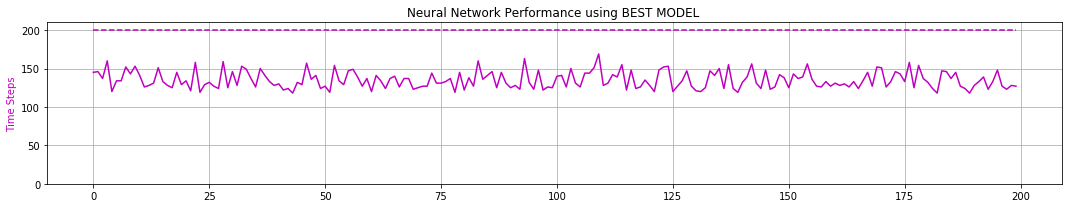

peak memory: 1504.88 MiB, increment: 996.18 MiB
0 -max- [ 0.152  0.566  0.047  0.919]
0 -min- [-2.399 -2.592 -0.209 -0.915]

1 -max- [ 0.205  0.552  0.048  0.953]
1 -min- [-2.399 -2.556 -0.209 -0.927]

2 -max- [ 0.147  0.612  0.048  0.716]
2 -min- [-2.399 -2.611 -0.209 -0.882]

3 -max- [ 0.174  0.630  0.047  0.823]
3 -min- [-2.398 -2.614 -0.209 -1.089]

4 -max- [ 0.153  0.615  0.048  0.777]
4 -min- [-2.400 -2.591 -0.209 -1.048]

5 -max- [ 0.148  0.600  0.049  0.934]
5 -min- [-2.400 -2.602 -0.209 -1.174]

6 -max- [ 0.149  0.578  0.049  0.921]
6 -min- [-2.399 -2.599 -0.209 -1.103]

7 -max- [ 0.204  0.634  0.049  0.681]
7 -min- [-2.400 -2.741 -0.209 -0.937]

8 -max- [ 0.156  0.620  0.050  0.942]
8 -min- [-2.399 -2.591 -0.209 -1.112]

9 -max- [ 0.200  0.440  0.048  0.881]
9 -min- [-2.399 -2.602 -0.209 -1.004]

Quantization TIME:  0.02 minutes


ITERATION # 5
TOTAL EXPERIENCE GENERATED:   115097
SMALLEST TIMESTEP: 42
LARGEST  TIMESTEP: 181
TOTAL SERIAL TIMESTEPS:   529683
TOTAL PARALLEL TIM

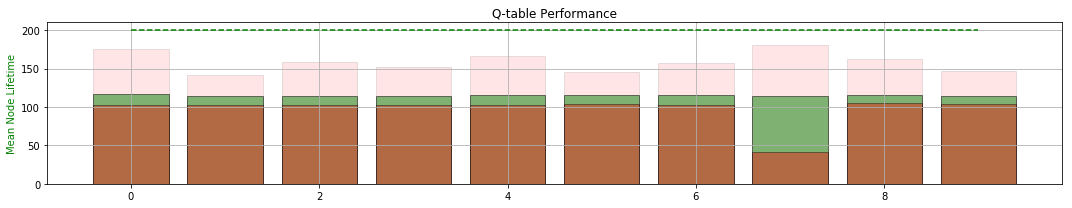

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 81.816	LOSS : 85.438	LOSS : 95.056	LOSS : 71.978	LOSS : 83.548	LOSS : 84.724	LOSS : 78.649	LOSS : 75.421	LOSS : 81.966	LOSS : 96.364	LOSS : 87.720	LOSS : 81.232	LOSS : 88.431	LOSS : 73.533	LOSS : 88.119	LOSS : 83.686	LOSS : 71.495	LOSS : 76.642	LOSS : 80.708	LOSS : 72.877	
Validating... MEAN TIME:  148.665
LOSS : 80.974	LOSS : 78.196	LOSS : 76.589	LOSS : 83.986	LOSS : 85.547	LOSS : 83.849	LOSS : 72.592	LOSS : 75.260	LOSS : 81.858	LOSS : 71.953	LOSS : 81.189	LOSS : 73.422	LOSS : 79.693	LOSS : 79.230	LOSS : 83.355	LOSS : 84.934	LOSS : 85.335	LOSS : 77.448	LOSS : 94.396	LOSS : 78.153	
Validating... MEAN TIME:  141.46
LOSS : 75.933	LOSS : 82.667	LOSS : 85.150	LOSS : 78.915	LOSS : 77.301	LOSS : 75.058	LOSS : 81.897	LOSS : 71.753	LOSS : 82.917	LOSS : 75.954	LOSS : 82.335	LOSS : 76.772	LOSS : 75.489	LOSS : 81.108	LOSS : 70.939	LOSS : 80.951	LOSS : 89.788	LOSS : 71.837	LOSS : 85.108	LOSS : 69.101	
Valida

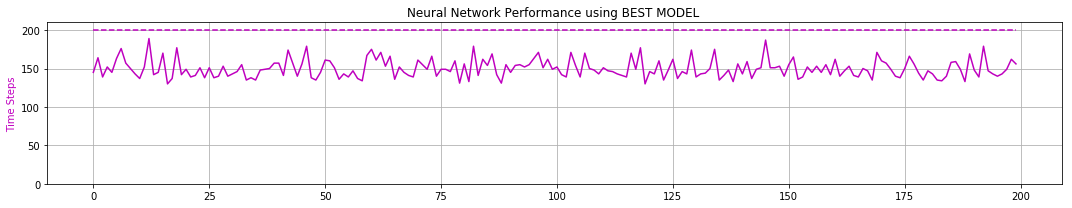

peak memory: 1506.98 MiB, increment: 978.55 MiB
0 -max- [ 0.205  0.618  0.051  0.878]
0 -min- [-2.399 -2.596 -0.195 -0.952]

1 -max- [ 0.153  0.589  0.048  0.886]
1 -min- [-2.400 -2.581 -0.209 -1.009]

2 -max- [ 0.174  0.567  0.046  0.960]
2 -min- [-2.400 -2.743 -0.190 -0.991]

3 -max- [ 0.153  0.577  0.048  0.926]
3 -min- [-2.400 -2.593 -0.202 -1.018]

4 -max- [ 0.184  0.560  0.054  0.931]
4 -min- [-2.398 -2.600 -0.185 -0.814]

5 -max- [ 0.136  0.609  0.050  0.919]
5 -min- [-2.400 -2.603 -0.184 -1.032]

6 -max- [ 0.187  0.619  0.049  0.706]
6 -min- [-2.400 -2.549 -0.177 -0.943]

7 -max- [ 0.156  0.549  0.050  0.871]
7 -min- [-2.400 -2.606 -0.201 -0.914]

8 -max- [ 0.204  0.602  0.048  0.760]
8 -min- [-2.400 -2.597 -0.172 -0.911]

9 -max- [ 0.130  0.598  0.048  0.920]
9 -min- [-2.400 -2.931 -0.196 -0.953]

Quantization TIME:  0.02 minutes


ITERATION # 6
TOTAL EXPERIENCE GENERATED:   123670
SMALLEST TIMESTEP: 53
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   653353
TOTAL PARALLEL TIM

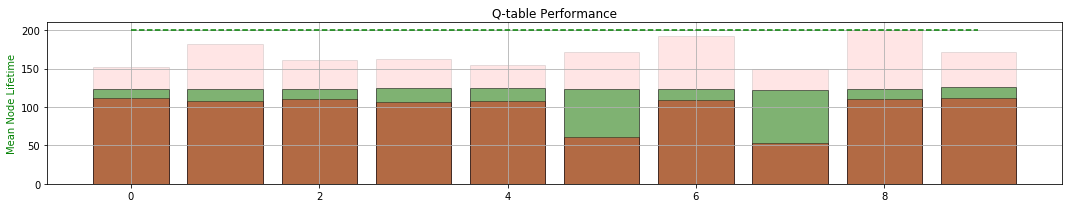

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 77.583	LOSS : 83.498	LOSS : 72.049	LOSS : 67.522	LOSS : 82.952	LOSS : 74.752	LOSS : 74.731	LOSS : 64.167	LOSS : 74.929	LOSS : 81.272	LOSS : 81.382	LOSS : 72.487	LOSS : 78.292	LOSS : 76.581	LOSS : 75.132	LOSS : 79.984	LOSS : 76.386	LOSS : 74.848	LOSS : 78.712	LOSS : 67.203	
Validating... MEAN TIME:  141.94
LOSS : 78.134	LOSS : 83.385	LOSS : 76.487	LOSS : 70.267	LOSS : 82.057	LOSS : 80.314	LOSS : 73.615	LOSS : 70.584	LOSS : 75.544	LOSS : 76.880	LOSS : 72.605	LOSS : 71.791	LOSS : 79.527	LOSS : 78.475	LOSS : 67.431	LOSS : 81.731	LOSS : 73.595	LOSS : 78.432	LOSS : 92.301	LOSS : 76.577	
Validating... MEAN TIME:  157.61
LOSS : 71.371	LOSS : 78.870	LOSS : 77.438	LOSS : 75.322	LOSS : 79.310	LOSS : 64.082	LOSS : 76.865	LOSS : 80.275	LOSS : 86.647	LOSS : 84.088	LOSS : 74.200	LOSS : 72.994	LOSS : 79.246	LOSS : 86.472	LOSS : 78.120	LOSS : 77.272	LOSS : 79.315	LOSS : 77.140	LOSS : 80.414	LOSS : 70.711	
Validat

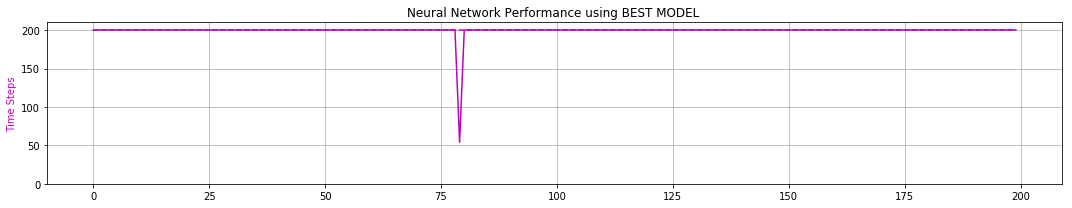

peak memory: 1454.58 MiB, increment: 990.78 MiB
0 -max- [ 0.140  0.439  0.068  0.999]
0 -min- [-2.400 -2.546 -0.189 -0.996]

1 -max- [ 0.188  0.630  0.082  0.937]
1 -min- [-2.400 -2.254 -0.181 -1.230]

2 -max- [ 0.147  0.552  0.069  0.994]
2 -min- [-2.400 -2.388 -0.176 -0.997]

3 -max- [ 0.148  0.573  0.071  1.338]
3 -min- [-2.400 -2.429 -0.193 -1.249]

4 -max- [ 0.128  0.597  0.068  0.998]
4 -min- [-2.399 -2.404 -0.178 -0.997]

5 -max- [ 0.228  0.600  0.194  1.052]
5 -min- [-2.400 -2.239 -0.191 -1.021]

6 -max- [ 0.150  0.597  0.071  0.967]
6 -min- [-2.400 -2.414 -0.192 -1.195]

7 -max- [ 0.222  0.578  0.208  1.047]
7 -min- [-2.400 -2.229 -0.177 -1.210]

8 -max- [ 0.182  0.632  0.083  0.998]
8 -min- [-2.400 -2.400 -0.187 -0.993]

9 -max- [ 0.184  0.631  0.063  0.737]
9 -min- [-2.399 -2.241 -0.197 -1.016]

Quantization TIME:  0.01 minutes


ITERATION # 7
TOTAL EXPERIENCE GENERATED:   42534
SMALLEST TIMESTEP: 9
LARGEST  TIMESTEP: 190
TOTAL SERIAL TIMESTEPS:   695887
TOTAL PARALLEL TIMES

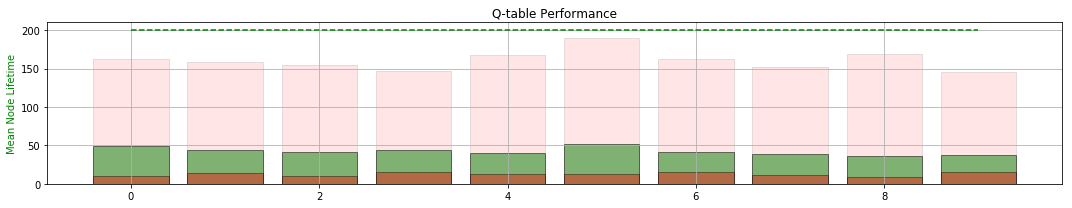

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 100.011	LOSS : 115.653	LOSS : 99.648	LOSS : 97.895	LOSS : 105.792	LOSS : 121.479	LOSS : 106.893	LOSS : 118.555	LOSS : 109.774	LOSS : 99.650	LOSS : 119.522	LOSS : 107.160	LOSS : 100.230	LOSS : 100.149	LOSS : 101.696	LOSS : 101.837	LOSS : 109.031	LOSS : 90.384	LOSS : 114.069	LOSS : 90.787	
Validating... MEAN TIME:  15.32
LOSS : 95.738	LOSS : 99.957	LOSS : 91.475	LOSS : 98.246	LOSS : 101.320	LOSS : 110.416	LOSS : 110.840	LOSS : 100.111	LOSS : 102.140	LOSS : 103.524	LOSS : 99.577	LOSS : 86.570	LOSS : 93.628	LOSS : 105.957	LOSS : 91.083	LOSS : 92.941	LOSS : 99.864	LOSS : 103.369	LOSS : 108.542	LOSS : 102.050	
Validating... MEAN TIME:  93.22
LOSS : 100.236	LOSS : 101.991	LOSS : 112.031	LOSS : 101.544	LOSS : 93.945	LOSS : 97.692	LOSS : 98.625	LOSS : 104.282	LOSS : 96.393	LOSS : 94.319	LOSS : 106.093	LOSS : 104.047	LOSS : 104.748	LOSS : 99.291	LOSS : 101.502	LOSS : 99.432	LOSS : 101.362	LOSS : 89.402	LOS

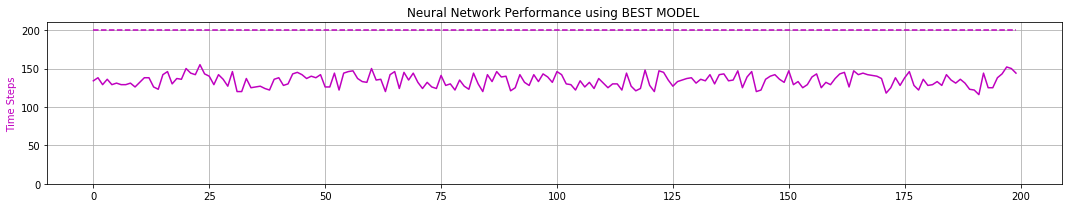

peak memory: 1432.75 MiB, increment: 995.67 MiB
0 -max- [ 0.049  0.437  0.208  2.669]
0 -min- [-2.400 -2.240 -0.196 -1.194]

1 -max- [ 0.049  0.262  0.209  2.156]
1 -min- [-2.400 -2.235 -0.186 -1.014]

2 -max- [ 0.051  0.238  0.209  2.231]
2 -min- [-2.400 -2.229 -0.191 -1.164]

3 -max- [ 0.050  0.546  0.208  2.459]
3 -min- [-2.398 -2.242 -0.186 -0.925]

4 -max- [ 0.050  0.237  0.208  2.515]
4 -min- [-2.399 -2.438 -0.191 -0.952]

5 -max- [ 0.051  0.589  0.209  2.463]
5 -min- [-2.399 -2.422 -0.205 -1.201]

6 -max- [ 0.048  0.232  0.206  2.154]
6 -min- [-2.399 -2.241 -0.184 -0.987]

7 -max- [ 0.050  0.562  0.209  2.384]
7 -min- [-2.396 -2.232 -0.207 -0.840]

8 -max- [ 0.051  0.248  0.209  2.718]
8 -min- [-2.399 -2.435 -0.182 -0.969]

9 -max- [ 0.049  0.537  0.208  2.720]
9 -min- [-2.398 -2.222 -0.189 -1.012]

Quantization TIME:  0.02 minutes


ITERATION # 8
TOTAL EXPERIENCE GENERATED:   107336
SMALLEST TIMESTEP: 38
LARGEST  TIMESTEP: 123
TOTAL SERIAL TIMESTEPS:   803223
TOTAL PARALLEL TIM

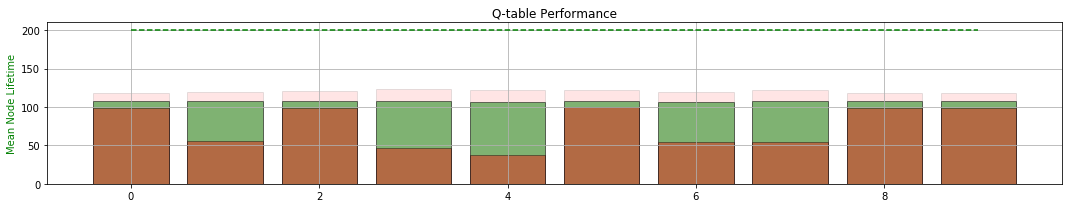

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 92.378	LOSS : 100.196	LOSS : 105.613	LOSS : 101.741	LOSS : 107.705	LOSS : 103.660	LOSS : 101.767	LOSS : 95.336	LOSS : 102.422	LOSS : 101.590	LOSS : 117.693	LOSS : 104.751	LOSS : 102.116	LOSS : 116.466	LOSS : 94.328	LOSS : 104.667	LOSS : 105.304	LOSS : 102.245	LOSS : 106.406	LOSS : 91.775	
Validating... MEAN TIME:  129.375
LOSS : 109.571	LOSS : 101.511	LOSS : 99.097	LOSS : 107.414	LOSS : 105.424	LOSS : 103.845	LOSS : 101.134	LOSS : 105.196	LOSS : 97.744	LOSS : 91.028	LOSS : 104.702	LOSS : 102.877	LOSS : 103.068	LOSS : 105.359	LOSS : 105.913	LOSS : 95.292	LOSS : 99.557	LOSS : 101.346	LOSS : 95.066	LOSS : 94.611	
Validating... MEAN TIME:  127.1
LOSS : 97.185	LOSS : 109.305	LOSS : 105.455	LOSS : 103.374	LOSS : 104.719	LOSS : 105.152	LOSS : 99.368	LOSS : 89.514	LOSS : 93.350	LOSS : 99.898	LOSS : 89.657	LOSS : 102.188	LOSS : 106.307	LOSS : 102.924	LOSS : 110.312	LOSS : 113.439	LOSS : 88.741	LOSS : 103.

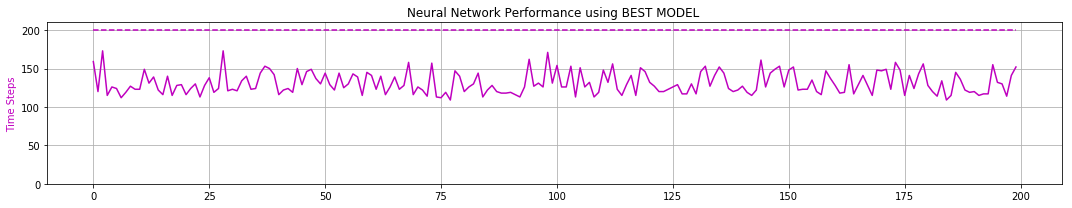

peak memory: 1474.11 MiB, increment: 978.43 MiB
0 -max- [ 0.143  0.625  0.048  0.721]
0 -min- [-2.398 -2.936 -0.207 -0.870]

1 -max- [ 0.147  0.630  0.049  0.929]
1 -min- [-2.400 -2.996 -0.205 -0.913]

2 -max- [ 0.133  0.629  0.049  0.922]
2 -min- [-2.399 -2.988 -0.208 -0.900]

3 -max- [ 0.160  0.615  0.049  0.723]
3 -min- [-2.400 -2.899 -0.208 -0.887]

4 -max- [ 0.146  0.632  0.052  0.833]
4 -min- [-2.400 -2.922 -0.207 -0.934]

5 -max- [ 0.167  0.634  0.048  0.812]
5 -min- [-2.400 -2.957 -0.206 -0.870]

6 -max- [ 0.143  0.823  0.048  0.726]
6 -min- [-2.400 -2.927 -0.209 -1.152]

7 -max- [ 0.161  0.631  0.051  0.941]
7 -min- [-2.400 -2.913 -0.204 -0.881]

8 -max- [ 0.130  0.628  0.049  0.900]
8 -min- [-2.400 -2.931 -0.207 -0.922]

9 -max- [ 0.137  0.630  0.050  0.943]
9 -min- [-2.400 -2.938 -0.205 -0.888]

Quantization TIME:  0.02 minutes


ITERATION # 9
TOTAL EXPERIENCE GENERATED:   74104
SMALLEST TIMESTEP: 34
LARGEST  TIMESTEP: 126
TOTAL SERIAL TIMESTEPS:   877327
TOTAL PARALLEL TIME

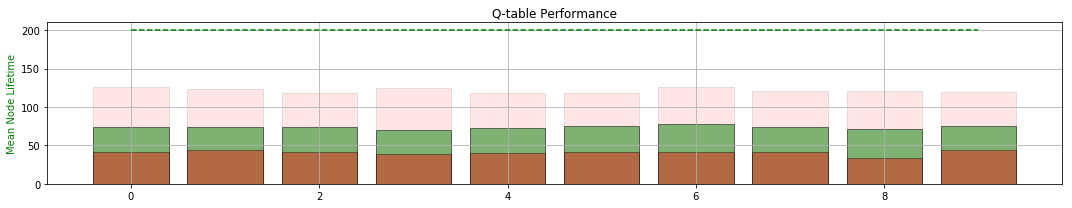

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 95.386	LOSS : 103.241	LOSS : 122.938	LOSS : 109.247	LOSS : 114.396	LOSS : 101.097	LOSS : 102.906	LOSS : 112.537	LOSS : 109.799	LOSS : 101.800	LOSS : 118.225	LOSS : 111.214	LOSS : 103.277	LOSS : 96.509	LOSS : 112.282	LOSS : 121.680	LOSS : 99.255	LOSS : 99.201	LOSS : 111.621	LOSS : 97.475	
Validating... MEAN TIME:  128.495
LOSS : 109.796	LOSS : 109.149	LOSS : 98.929	LOSS : 108.362	LOSS : 108.960	LOSS : 108.141	LOSS : 101.626	LOSS : 111.829	LOSS : 103.990	LOSS : 116.813	LOSS : 108.032	LOSS : 109.058	LOSS : 101.516	LOSS : 104.116	LOSS : 100.071	LOSS : 101.943	LOSS : 96.822	LOSS : 119.787	LOSS : 117.205	LOSS : 105.268	
Validating... MEAN TIME:  121.8
LOSS : 103.029	LOSS : 109.022	LOSS : 101.898	LOSS : 107.523	LOSS : 106.442	LOSS : 108.382	LOSS : 110.374	LOSS : 106.472	LOSS : 100.902	LOSS : 102.620	LOSS : 100.145	LOSS : 105.904	LOSS : 113.348	LOSS : 98.620	LOSS : 111.567	LOSS : 107.920	LOSS : 96.754	LO

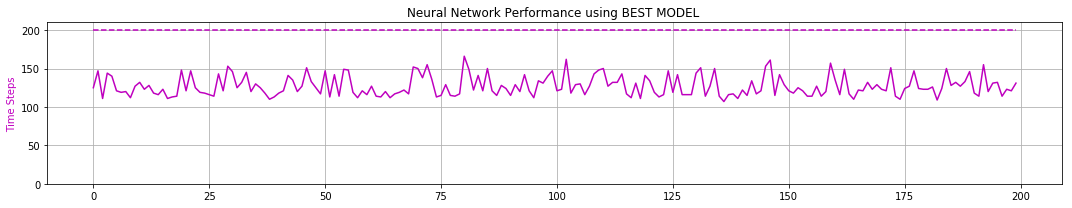

peak memory: 1482.59 MiB, increment: 1054.77 MiB
0 -max- [ 0.153  0.620  0.049  0.974]
0 -min- [-2.398 -3.287 -0.209 -0.844]

1 -max- [ 0.136  0.555  0.049  0.958]
1 -min- [-2.398 -3.172 -0.209 -0.879]

2 -max- [ 0.166  0.439  0.049  0.926]
2 -min- [-2.398 -3.173 -0.209 -0.877]

3 -max- [ 0.153  0.548  0.050  0.983]
3 -min- [-2.399 -3.323 -0.209 -1.080]

4 -max- [ 0.186  0.440  0.048  0.890]
4 -min- [-2.397 -3.174 -0.209 -0.837]

5 -max- [ 0.128  0.590  0.048  0.944]
5 -min- [-2.398 -3.318 -0.209 -1.047]

6 -max- [ 0.162  0.602  0.051  0.962]
6 -min- [-2.400 -3.166 -0.209 -0.897]

7 -max- [ 0.136  0.549  0.049  0.954]
7 -min- [-2.400 -3.157 -0.209 -0.817]

8 -max- [ 0.140  0.438  0.050  0.725]
8 -min- [-2.400 -3.175 -0.209 -0.855]

9 -max- [ 0.158  0.594  0.050  0.902]
9 -min- [-2.394 -3.164 -0.209 -0.861]

Quantization TIME:  0.02 minutes


ITERATION # 10
TOTAL EXPERIENCE GENERATED:   53017
SMALLEST TIMESTEP: 36
LARGEST  TIMESTEP: 74
TOTAL SERIAL TIMESTEPS:   930344
TOTAL PARALLEL TIM

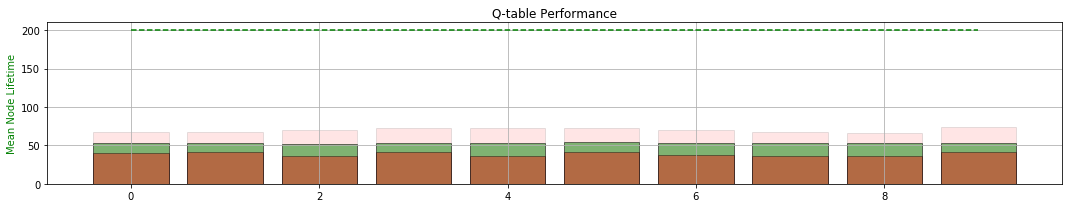

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 106.963	LOSS : 146.963	LOSS : 116.679	LOSS : 123.300	LOSS : 137.051	LOSS : 125.619	LOSS : 141.354	LOSS : 116.996	LOSS : 126.162	LOSS : 125.525	LOSS : 120.671	LOSS : 121.235	LOSS : 120.951	LOSS : 119.177	LOSS : 113.943	LOSS : 122.424	LOSS : 127.905	LOSS : 126.660	LOSS : 105.717	LOSS : 118.166	
Validating... MEAN TIME:  199.925
LOSS : 128.694	LOSS : 137.748	LOSS : 126.174	LOSS : 120.972	LOSS : 136.609	LOSS : 135.616	LOSS : 127.680	LOSS : 121.250	LOSS : 136.190	LOSS : 127.383	LOSS : 130.301	LOSS : 134.143	LOSS : 130.885	LOSS : 104.710	LOSS : 117.178	LOSS : 124.012	LOSS : 120.099	LOSS : 125.038	LOSS : 113.884	LOSS : 131.861	
Validating... MEAN TIME:  138.355
LOSS : 131.006	LOSS : 122.864	LOSS : 120.921	LOSS : 122.799	LOSS : 131.123	LOSS : 122.312	LOSS : 110.262	LOSS : 132.533	LOSS : 112.354	LOSS : 110.949	LOSS : 124.120	LOSS : 130.871	LOSS : 120.472	LOSS : 124.093	LOSS : 132.348	LOSS : 121.483	LOSS :

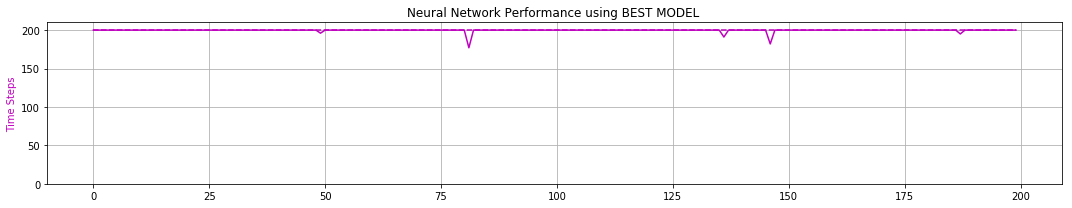

peak memory: 1484.25 MiB, increment: 1017.24 MiB
0 -max- [ 0.134  0.601  0.049  0.366]
0 -min- [-0.450 -1.333 -0.209 -0.864]

1 -max- [ 0.164  0.615  0.049  0.356]
1 -min- [-0.418 -1.261 -0.209 -0.850]

2 -max- [ 0.149  0.550  0.050  0.380]
2 -min- [-0.327 -1.137 -0.209 -0.879]

3 -max- [ 0.177  0.614  0.048  0.370]
3 -min- [-0.382 -1.239 -0.209 -0.881]

4 -max- [ 0.135  0.620  0.048  0.378]
4 -min- [-0.399 -1.291 -0.209 -1.127]

5 -max- [ 0.175  0.539  0.051  0.363]
5 -min- [-0.339 -1.263 -0.209 -0.979]

6 -max- [ 0.133  0.634  0.049  0.385]
6 -min- [-0.449 -1.318 -0.209 -0.861]

7 -max- [ 0.140  0.583  0.050  0.361]
7 -min- [-0.370 -1.252 -0.209 -0.881]

8 -max- [ 0.160  0.575  0.050  0.348]
8 -min- [-0.370 -1.240 -0.209 -0.816]

9 -max- [ 0.145  0.595  0.049  0.543]
9 -min- [-0.328 -1.141 -0.209 -0.855]

Quantization TIME:  0.01 minutes


ITERATION # 11
TOTAL EXPERIENCE GENERATED:   154652
SMALLEST TIMESTEP: 124
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   1084996
TOTAL PARALLEL

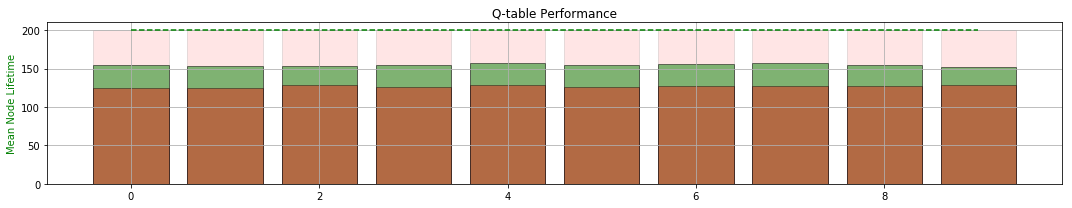

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 94.372	LOSS : 85.373	LOSS : 85.578	LOSS : 95.782	LOSS : 88.952	LOSS : 82.222	LOSS : 79.509	LOSS : 91.016	LOSS : 80.871	LOSS : 87.432	LOSS : 95.078	LOSS : 81.919	LOSS : 89.578	LOSS : 86.355	LOSS : 88.083	LOSS : 99.506	LOSS : 92.623	LOSS : 86.531	LOSS : 77.412	LOSS : 80.181	
Validating... MEAN TIME:  200.0
LOSS : 77.346	LOSS : 89.713	LOSS : 90.662	LOSS : 88.733	LOSS : 101.351	LOSS : 87.263	LOSS : 105.331	LOSS : 82.700	LOSS : 76.235	LOSS : 79.652	LOSS : 74.567	LOSS : 82.641	LOSS : 82.442	LOSS : 77.626	LOSS : 80.130	LOSS : 89.421	LOSS : 83.262	LOSS : 99.924	LOSS : 80.702	LOSS : 75.436	
Validating... MEAN TIME:  200.0
LOSS : 80.168	LOSS : 85.801	LOSS : 94.821	LOSS : 79.757	LOSS : 84.578	LOSS : 82.414	LOSS : 80.561	LOSS : 68.602	LOSS : 87.925	LOSS : 85.933	LOSS : 82.692	LOSS : 91.706	LOSS : 79.210	LOSS : 79.429	LOSS : 81.282	LOSS : 80.223	LOSS : 90.455	LOSS : 79.845	LOSS : 85.810	LOSS : 90.275	
Validat

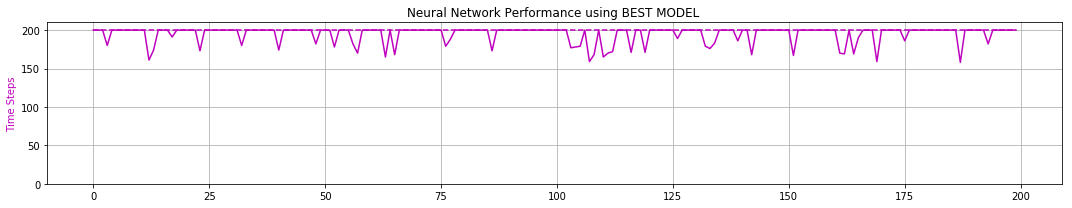

peak memory: 1469.73 MiB, increment: 1035.11 MiB
0 -max- [ 0.204  0.761  0.123  0.941]
0 -min- [-2.397 -2.391 -0.148 -0.990]

1 -max- [ 0.177  0.624  0.125  1.147]
1 -min- [-2.399 -2.431 -0.152 -0.950]

2 -max- [ 0.216  0.436  0.122  0.911]
2 -min- [-2.400 -2.412 -0.151 -0.768]

3 -max- [ 0.171  0.593  0.123  1.017]
3 -min- [-2.399 -2.454 -0.144 -0.888]

4 -max- [ 0.189  0.567  0.128  1.047]
4 -min- [-2.400 -2.443 -0.158 -0.798]

5 -max- [ 0.202  0.431  0.134  0.955]
5 -min- [-2.400 -2.260 -0.137 -0.725]

6 -max- [ 0.172  0.582  0.133  1.091]
6 -min- [-2.400 -2.381 -0.147 -0.758]

7 -max- [ 0.194  0.435  0.131  0.999]
7 -min- [-2.400 -2.418 -0.138 -0.725]

8 -max- [ 0.171  0.567  0.136  0.940]
8 -min- [-2.399 -2.418 -0.152 -0.779]

9 -max- [ 0.182  0.536  0.139  1.346]
9 -min- [-2.399 -2.650 -0.146 -0.756]

Quantization TIME:  0.01 minutes


ITERATION # 12
TOTAL EXPERIENCE GENERATED:   120957
SMALLEST TIMESTEP: 106
LARGEST  TIMESTEP: 140
TOTAL SERIAL TIMESTEPS:   1205953
TOTAL PARALLEL

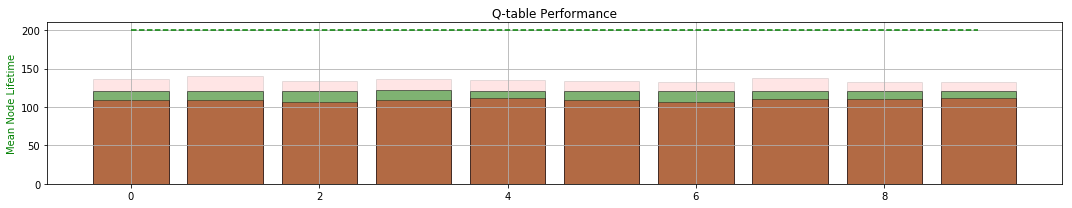

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 63.999	LOSS : 69.403	LOSS : 75.628	LOSS : 77.833	LOSS : 59.270	LOSS : 74.184	LOSS : 69.820	LOSS : 68.364	LOSS : 74.974	LOSS : 74.227	LOSS : 68.923	LOSS : 68.047	LOSS : 69.216	LOSS : 62.773	LOSS : 73.942	LOSS : 66.726	LOSS : 70.673	LOSS : 69.267	LOSS : 68.565	LOSS : 60.305	
Validating... MEAN TIME:  130.195
LOSS : 72.919	LOSS : 75.634	LOSS : 66.164	LOSS : 67.902	LOSS : 73.282	LOSS : 73.291	LOSS : 71.403	LOSS : 65.541	LOSS : 69.743	LOSS : 66.509	LOSS : 67.815	LOSS : 75.111	LOSS : 73.893	LOSS : 75.988	LOSS : 67.578	LOSS : 68.609	LOSS : 63.492	LOSS : 59.292	LOSS : 60.040	LOSS : 67.934	
Validating... MEAN TIME:  134.825
LOSS : 61.317	LOSS : 59.402	LOSS : 61.051	LOSS : 82.997	LOSS : 65.818	LOSS : 66.665	LOSS : 73.231	LOSS : 70.962	LOSS : 71.333	LOSS : 62.873	LOSS : 74.976	LOSS : 69.947	LOSS : 72.430	LOSS : 76.791	LOSS : 65.066	LOSS : 73.106	LOSS : 59.129	LOSS : 73.783	LOSS : 64.495	LOSS : 73.756	
Valid

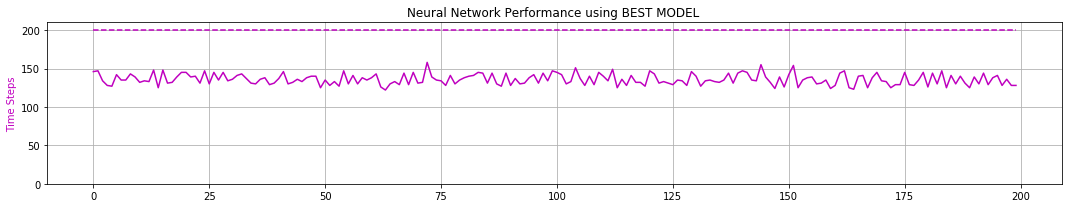

peak memory: 1464.68 MiB, increment: 997.46 MiB
0 -max- [ 0.159  0.590  0.209  1.186]
0 -min- [-2.399 -2.428 -0.166 -0.957]

1 -max- [ 0.183  0.596  0.209  1.079]
1 -min- [-2.400 -2.232 -0.160 -0.950]

2 -max- [ 0.139  0.625  0.209  1.144]
2 -min- [-2.398 -2.232 -0.174 -0.875]

3 -max- [ 0.168  0.631  0.209  1.090]
3 -min- [-2.400 -2.274 -0.165 -0.909]

4 -max- [ 0.145  0.572  0.209  1.095]
4 -min- [-2.398 -2.419 -0.176 -0.871]

5 -max- [ 0.152  0.617  0.209  1.074]
5 -min- [-2.398 -2.197 -0.179 -0.951]

6 -max- [ 0.165  0.633  0.209  1.120]
6 -min- [-2.394 -2.401 -0.170 -0.933]

7 -max- [ 0.144  0.625  0.209  1.371]
7 -min- [-2.395 -2.202 -0.160 -0.987]

8 -max- [ 0.131  0.604  0.209  1.114]
8 -min- [-2.393 -2.273 -0.169 -0.933]

9 -max- [ 0.145  0.610  0.209  1.117]
9 -min- [-2.394 -2.202 -0.169 -0.808]

Quantization TIME:  0.02 minutes


ITERATION # 13
TOTAL EXPERIENCE GENERATED:   112025
SMALLEST TIMESTEP: 55
LARGEST  TIMESTEP: 137
TOTAL SERIAL TIMESTEPS:   1317978
TOTAL PARALLEL T

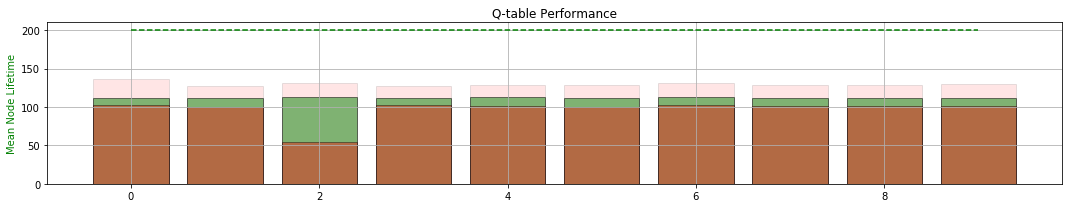

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 74.919	LOSS : 71.610	LOSS : 75.208	LOSS : 73.627	LOSS : 71.268	LOSS : 81.394	LOSS : 77.685	LOSS : 72.441	LOSS : 79.192	LOSS : 79.803	LOSS : 79.047	LOSS : 75.011	LOSS : 83.092	LOSS : 72.319	LOSS : 83.757	LOSS : 69.397	LOSS : 81.738	LOSS : 83.896	LOSS : 77.740	LOSS : 71.585	
Validating... MEAN TIME:  117.765
LOSS : 79.713	LOSS : 70.207	LOSS : 70.711	LOSS : 78.676	LOSS : 90.653	LOSS : 66.575	LOSS : 60.654	LOSS : 77.131	LOSS : 79.130	LOSS : 77.250	LOSS : 77.529	LOSS : 84.018	LOSS : 74.990	LOSS : 80.101	LOSS : 77.374	LOSS : 74.230	LOSS : 78.514	LOSS : 73.590	LOSS : 67.713	LOSS : 84.142	
Validating... MEAN TIME:  119.41
LOSS : 73.614	LOSS : 85.407	LOSS : 78.133	LOSS : 70.906	LOSS : 85.032	LOSS : 75.362	LOSS : 79.611	LOSS : 66.806	LOSS : 79.253	LOSS : 69.900	LOSS : 72.537	LOSS : 61.183	LOSS : 71.635	LOSS : 76.444	LOSS : 79.851	LOSS : 73.799	LOSS : 83.061	LOSS : 65.656	LOSS : 77.927	LOSS : 83.977	
Valida

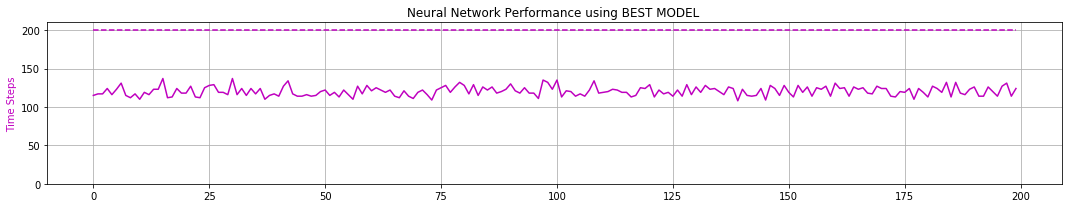

peak memory: 1453.04 MiB, increment: 1004.98 MiB
0 -max- [ 0.177  0.440  0.106  0.980]
0 -min- [-2.400 -2.769 -0.196 -0.814]

1 -max- [ 0.127  0.620  0.119  1.075]
1 -min- [-2.399 -2.824 -0.209 -1.107]

2 -max- [ 0.164  0.558  0.112  0.991]
2 -min- [-2.400 -2.612 -0.208 -1.131]

3 -max- [ 0.133  0.535  0.107  1.015]
3 -min- [-2.399 -2.636 -0.173 -0.820]

4 -max- [ 0.140  0.440  0.111  1.034]
4 -min- [-2.400 -2.732 -0.187 -0.775]

5 -max- [ 0.160  0.633  0.107  1.045]
5 -min- [-2.400 -2.784 -0.194 -0.933]

6 -max- [ 0.137  0.606  0.109  0.941]
6 -min- [-2.399 -2.629 -0.176 -0.890]

7 -max- [ 0.127  0.588  0.107  1.268]
7 -min- [-2.400 -2.831 -0.196 -0.804]

8 -max- [ 0.135  0.601  0.114  0.984]
8 -min- [-2.400 -2.726 -0.190 -0.855]

9 -max- [ 0.129  0.565  0.111  0.854]
9 -min- [-2.400 -2.588 -0.177 -0.839]

Quantization TIME:  0.02 minutes


ITERATION # 14
TOTAL EXPERIENCE GENERATED:   111964
SMALLEST TIMESTEP: 43
LARGEST  TIMESTEP: 143
TOTAL SERIAL TIMESTEPS:   1429942
TOTAL PARALLEL 

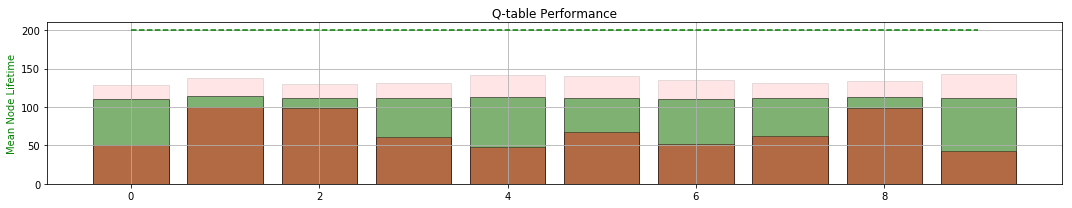

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 76.392	LOSS : 75.628	LOSS : 81.222	LOSS : 79.392	LOSS : 81.419	LOSS : 83.503	LOSS : 72.380	LOSS : 71.658	LOSS : 77.190	LOSS : 82.111	LOSS : 84.987	LOSS : 78.623	LOSS : 69.148	LOSS : 80.040	LOSS : 77.605	LOSS : 86.051	LOSS : 70.534	LOSS : 84.149	LOSS : 75.885	LOSS : 72.227	
Validating... MEAN TIME:  113.405
LOSS : 83.537	LOSS : 79.107	LOSS : 62.162	LOSS : 76.035	LOSS : 84.169	LOSS : 65.699	LOSS : 78.436	LOSS : 80.307	LOSS : 78.543	LOSS : 72.968	LOSS : 74.706	LOSS : 80.140	LOSS : 77.071	LOSS : 73.363	LOSS : 76.507	LOSS : 85.849	LOSS : 84.412	LOSS : 71.508	LOSS : 78.368	LOSS : 72.333	
Validating... MEAN TIME:  112.295
LOSS : 74.043	LOSS : 70.749	LOSS : 88.239	LOSS : 74.649	LOSS : 81.937	LOSS : 83.308	LOSS : 82.238	LOSS : 69.428	LOSS : 75.340	LOSS : 74.795	LOSS : 82.088	LOSS : 72.143	LOSS : 87.209	LOSS : 78.798	LOSS : 79.695	LOSS : 72.407	LOSS : 84.719	LOSS : 80.202	LOSS : 75.412	LOSS : 80.732	
Valid

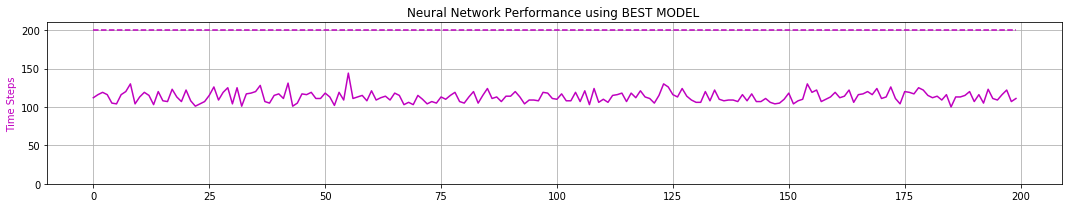

peak memory: 1484.47 MiB, increment: 1016.76 MiB
0 -max- [ 0.119  0.585  0.048  0.992]
0 -min- [-2.398 -2.974 -0.207 -1.007]

1 -max- [ 0.163  0.569  0.051  0.923]
1 -min- [-2.399 -2.999 -0.206 -0.863]

2 -max- [ 0.130  0.570  0.049  0.955]
2 -min- [-2.400 -2.935 -0.209 -0.882]

3 -max- [ 0.131  0.594  0.050  0.898]
3 -min- [-2.400 -2.922 -0.205 -0.887]

4 -max- [ 0.155  0.605  0.054  1.027]
4 -min- [-2.399 -3.092 -0.208 -0.863]

5 -max- [ 0.136  0.599  0.049  0.917]
5 -min- [-2.400 -2.984 -0.208 -0.881]

6 -max- [ 0.121  0.629  0.053  0.963]
6 -min- [-2.400 -2.935 -0.209 -0.877]

7 -max- [ 0.125  0.576  0.050  0.969]
7 -min- [-2.400 -2.954 -0.207 -0.873]

8 -max- [ 0.119  0.595  0.050  1.000]
8 -min- [-2.400 -2.986 -0.203 -0.913]

9 -max- [ 0.153  0.562  0.048  0.974]
9 -min- [-2.400 -2.997 -0.208 -0.862]

Quantization TIME:  0.02 minutes


ITERATION # 15
TOTAL EXPERIENCE GENERATED:   108928
SMALLEST TIMESTEP: 47
LARGEST  TIMESTEP: 159
TOTAL SERIAL TIMESTEPS:   1538870
TOTAL PARALLEL 

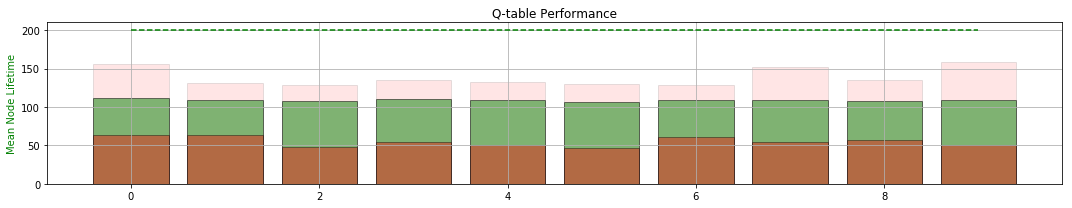

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 74.825	LOSS : 89.020	LOSS : 81.496	LOSS : 78.187	LOSS : 70.523	LOSS : 80.000	LOSS : 76.497	LOSS : 79.415	LOSS : 77.383	LOSS : 74.180	LOSS : 78.381	LOSS : 73.762	LOSS : 70.996	LOSS : 73.627	LOSS : 68.728	LOSS : 77.061	LOSS : 73.116	LOSS : 74.907	LOSS : 70.080	LOSS : 79.132	
Validating... MEAN TIME:  110.94
LOSS : 78.749	LOSS : 82.314	LOSS : 79.496	LOSS : 72.551	LOSS : 73.352	LOSS : 70.650	LOSS : 79.313	LOSS : 77.072	LOSS : 67.848	LOSS : 76.688	LOSS : 77.846	LOSS : 70.257	LOSS : 76.715	LOSS : 70.413	LOSS : 81.397	LOSS : 69.435	LOSS : 70.260	LOSS : 76.878	LOSS : 77.919	LOSS : 72.416	
Validating... MEAN TIME:  114.59
LOSS : 80.256	LOSS : 81.797	LOSS : 80.915	LOSS : 69.580	LOSS : 74.441	LOSS : 77.584	LOSS : 79.250	LOSS : 67.489	LOSS : 66.883	LOSS : 57.716	LOSS : 73.172	LOSS : 78.523	LOSS : 76.921	LOSS : 75.632	LOSS : 84.211	LOSS : 73.188	LOSS : 69.637	LOSS : 67.629	LOSS : 67.478	LOSS : 83.194	
Validat

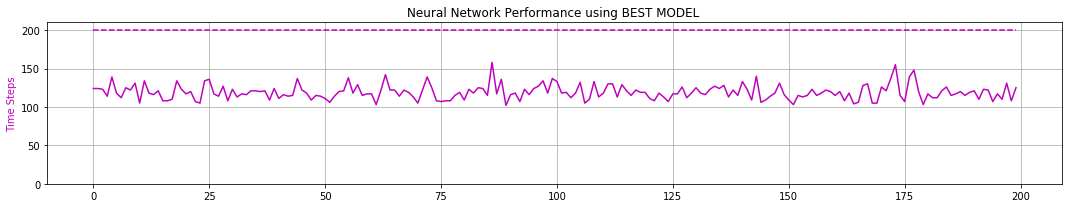

peak memory: 1458.29 MiB, increment: 1036.03 MiB
0 -max- [ 0.188  0.568  0.051  0.836]
0 -min- [-2.399 -3.263 -0.209 -0.873]

1 -max- [ 0.128  0.614  0.055  0.724]
1 -min- [-2.400 -3.342 -0.209 -0.882]

2 -max- [ 0.131  0.626  0.050  0.923]
2 -min- [-2.400 -3.348 -0.209 -0.895]

3 -max- [ 0.158  0.575  0.050  0.718]
3 -min- [-2.400 -3.289 -0.209 -0.863]

4 -max- [ 0.131  0.621  0.049  0.918]
4 -min- [-2.400 -3.339 -0.209 -0.881]

5 -max- [ 0.121  0.577  0.050  0.850]
5 -min- [-2.400 -3.328 -0.207 -0.877]

6 -max- [ 0.128  0.564  0.050  0.862]
6 -min- [-2.399 -3.276 -0.209 -0.873]

7 -max- [ 0.141  0.575  0.050  0.792]
7 -min- [-2.399 -3.285 -0.208 -0.881]

8 -max- [ 0.140  0.733  0.048  0.720]
8 -min- [-2.400 -3.327 -0.209 -1.146]

9 -max- [ 0.205  0.566  0.050  0.796]
9 -min- [-2.400 -3.305 -0.209 -0.884]

Quantization TIME:  0.01 minutes


ITERATION # 16
TOTAL EXPERIENCE GENERATED:   123590
SMALLEST TIMESTEP: 53
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   1662460
TOTAL PARALLEL 

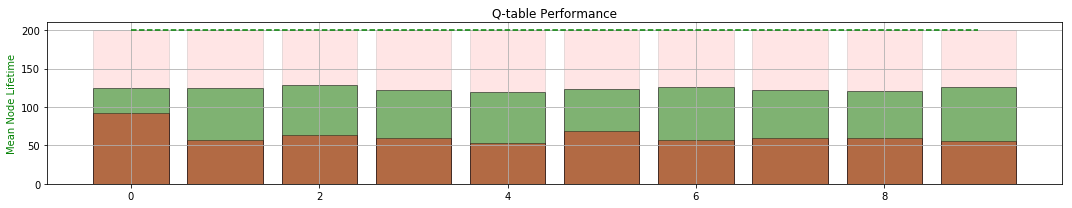

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 70.409	LOSS : 73.558	LOSS : 67.867	LOSS : 71.629	LOSS : 67.310	LOSS : 75.121	LOSS : 62.272	LOSS : 80.727	LOSS : 77.503	LOSS : 66.157	LOSS : 71.683	LOSS : 76.361	LOSS : 78.422	LOSS : 72.065	LOSS : 67.146	LOSS : 74.290	LOSS : 72.463	LOSS : 72.161	LOSS : 69.078	LOSS : 62.625	
Validating... MEAN TIME:  124.175
LOSS : 79.272	LOSS : 81.984	LOSS : 77.502	LOSS : 72.471	LOSS : 70.552	LOSS : 74.620	LOSS : 80.430	LOSS : 74.757	LOSS : 72.850	LOSS : 73.416	LOSS : 76.327	LOSS : 74.077	LOSS : 64.962	LOSS : 72.919	LOSS : 75.990	LOSS : 76.813	LOSS : 78.157	LOSS : 77.327	LOSS : 63.678	LOSS : 78.097	
Validating... MEAN TIME:  121.225
LOSS : 64.130	LOSS : 62.999	LOSS : 65.872	LOSS : 68.109	LOSS : 72.695	LOSS : 74.267	LOSS : 63.635	LOSS : 67.455	LOSS : 69.464	LOSS : 74.863	LOSS : 72.257	LOSS : 68.457	LOSS : 70.308	LOSS : 64.327	LOSS : 66.691	LOSS : 65.153	LOSS : 81.204	LOSS : 68.211	LOSS : 66.449	LOSS : 74.126	
Valid

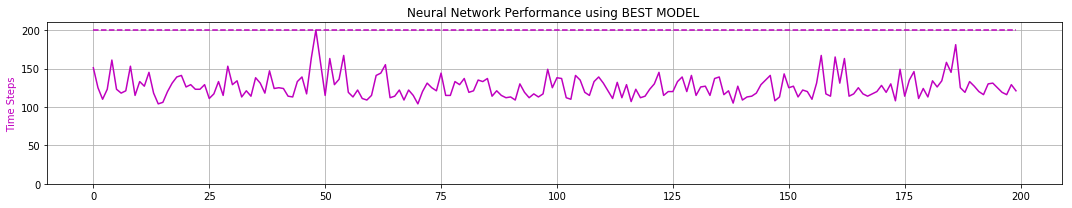

peak memory: 1458.28 MiB, increment: 977.44 MiB
0 -max- [ 1.051  1.597  0.209  0.644]
0 -min- [-2.400 -3.290 -0.209 -1.042]

1 -max- [ 0.913  1.409  0.203  0.682]
1 -min- [-2.400 -3.245 -0.209 -0.982]

2 -max- [ 0.199  0.434  0.050  0.664]
2 -min- [-2.399 -3.142 -0.209 -1.012]

3 -max- [ 1.038  1.492  0.208  0.827]
3 -min- [-2.399 -3.155 -0.209 -0.847]

4 -max- [ 0.417  0.594  0.110  0.818]
4 -min- [-2.398 -3.150 -0.209 -0.854]

5 -max- [ 1.050  1.502  0.205  0.709]
5 -min- [-2.398 -3.152 -0.209 -0.778]

6 -max- [ 1.033  1.494  0.208  0.649]
6 -min- [-2.398 -3.155 -0.209 -0.866]

7 -max- [ 1.045  1.504  0.209  0.933]
7 -min- [-2.399 -3.153 -0.209 -1.063]

8 -max- [ 1.041  1.484  0.209  0.735]
8 -min- [-2.399 -3.141 -0.209 -0.949]

9 -max- [ 1.079  1.660  0.208  0.664]
9 -min- [-2.399 -3.146 -0.209 -1.025]

Quantization TIME:  0.02 minutes


ITERATION # 17
TOTAL EXPERIENCE GENERATED:   109444
SMALLEST TIMESTEP: 63
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   1771904
TOTAL PARALLEL T

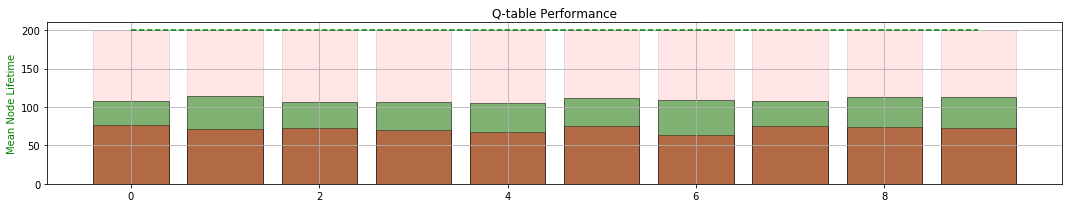

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 71.316	LOSS : 81.474	LOSS : 77.808	LOSS : 76.255	LOSS : 82.750	LOSS : 79.688	LOSS : 88.419	LOSS : 71.127	LOSS : 87.630	LOSS : 78.167	LOSS : 73.211	LOSS : 75.108	LOSS : 83.529	LOSS : 80.399	LOSS : 78.935	LOSS : 79.929	LOSS : 83.467	LOSS : 86.453	LOSS : 72.293	LOSS : 80.186	
Validating... MEAN TIME:  152.38
LOSS : 84.852	LOSS : 86.951	LOSS : 81.116	LOSS : 78.758	LOSS : 75.864	LOSS : 89.735	LOSS : 77.894	LOSS : 85.095	LOSS : 78.327	LOSS : 74.404	LOSS : 87.326	LOSS : 75.800	LOSS : 88.939	LOSS : 84.866	LOSS : 74.559	LOSS : 81.500	LOSS : 81.598	LOSS : 73.647	LOSS : 73.738	LOSS : 66.475	
Validating... MEAN TIME:  158.795
LOSS : 82.088	LOSS : 76.946	LOSS : 73.160	LOSS : 87.932	LOSS : 76.276	LOSS : 80.668	LOSS : 74.267	LOSS : 89.859	LOSS : 80.042	LOSS : 87.803	LOSS : 81.343	LOSS : 80.933	LOSS : 80.851	LOSS : 73.854	LOSS : 76.379	LOSS : 88.826	LOSS : 73.880	LOSS : 80.449	LOSS : 73.614	LOSS : 87.566	
Valida

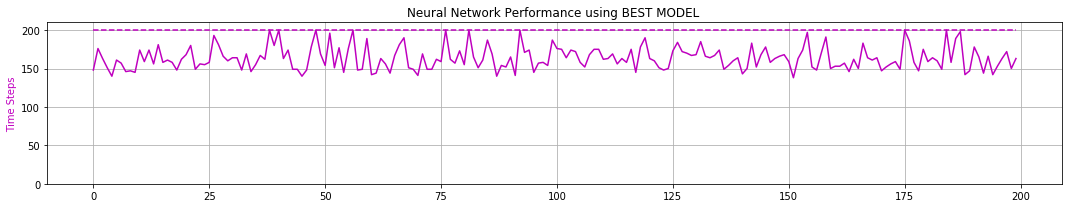

peak memory: 1458.28 MiB, increment: 996.85 MiB
0 -max- [ 0.356  0.570  0.073  0.640]
0 -min- [-1.675 -2.591 -0.209 -0.850]

1 -max- [ 0.206  0.437  0.050  0.678]
1 -min- [-1.625 -2.555 -0.209 -0.977]

2 -max- [ 1.141  1.510  0.206  0.797]
2 -min- [-1.659 -2.547 -0.209 -0.827]

3 -max- [ 0.476  0.794  0.088  0.567]
3 -min- [-1.655 -2.608 -0.209 -0.871]

4 -max- [ 1.174  1.509  0.209  0.780]
4 -min- [-1.669 -2.550 -0.209 -1.086]

5 -max- [ 1.168  1.498  0.208  0.762]
5 -min- [-1.878 -2.585 -0.209 -0.837]

6 -max- [ 1.183  1.683  0.208  0.671]
6 -min- [-1.765 -2.590 -0.209 -0.883]

7 -max- [ 1.102  1.486  0.209  0.704]
7 -min- [-1.909 -2.714 -0.209 -0.873]

8 -max- [ 1.102  1.502  0.209  0.694]
8 -min- [-1.681 -2.599 -0.209 -0.786]

9 -max- [ 1.131  1.494  0.206  0.917]
9 -min- [-1.670 -2.588 -0.209 -0.799]

Quantization TIME:  0.01 minutes


ITERATION # 18
TOTAL EXPERIENCE GENERATED:   138315
SMALLEST TIMESTEP: 69
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   1910219
TOTAL PARALLEL T

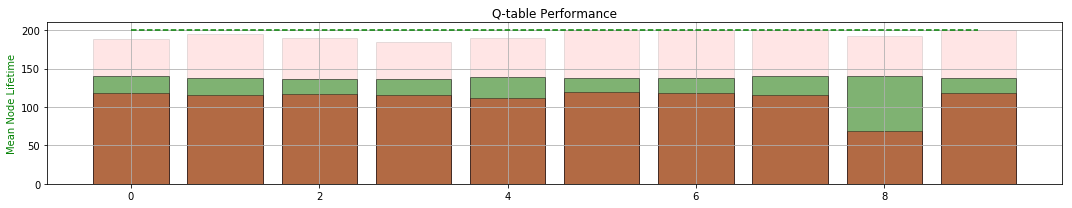

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 81.392	LOSS : 58.903	LOSS : 74.574	LOSS : 65.143	LOSS : 71.981	LOSS : 64.091	LOSS : 75.815	LOSS : 69.945	LOSS : 65.788	LOSS : 68.839	LOSS : 67.953	LOSS : 72.639	LOSS : 66.511	LOSS : 69.112	LOSS : 70.716	LOSS : 68.830	LOSS : 76.324	LOSS : 70.915	LOSS : 62.155	LOSS : 72.767	
Validating... MEAN TIME:  133.135
LOSS : 67.228	LOSS : 70.568	LOSS : 70.038	LOSS : 69.517	LOSS : 65.361	LOSS : 60.092	LOSS : 66.176	LOSS : 69.718	LOSS : 67.668	LOSS : 63.025	LOSS : 69.418	LOSS : 61.647	LOSS : 70.102	LOSS : 64.588	LOSS : 60.914	LOSS : 70.920	LOSS : 82.624	LOSS : 61.171	LOSS : 57.703	LOSS : 64.067	
Validating... MEAN TIME:  137.76
LOSS : 70.183	LOSS : 67.038	LOSS : 68.181	LOSS : 65.682	LOSS : 76.860	LOSS : 65.458	LOSS : 59.870	LOSS : 71.954	LOSS : 63.715	LOSS : 63.705	LOSS : 70.795	LOSS : 60.627	LOSS : 69.603	LOSS : 70.437	LOSS : 68.254	LOSS : 64.300	LOSS : 67.939	LOSS : 67.278	LOSS : 64.385	LOSS : 70.323	
Valida

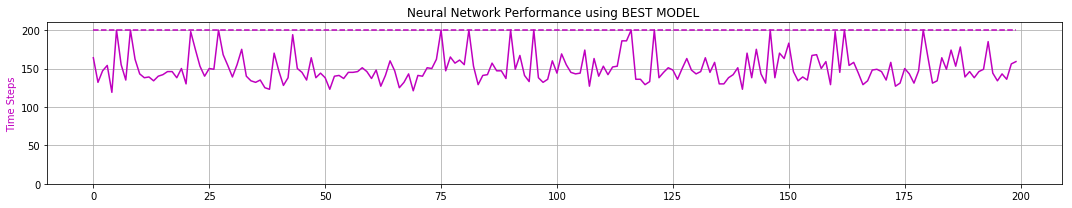

peak memory: 1497.34 MiB, increment: 977.20 MiB
0 -max- [ 0.127  0.622  0.050  0.688]
0 -min- [-2.388 -2.573 -0.209 -0.836]

1 -max- [ 0.134  0.628  0.049  0.709]
1 -min- [-2.384 -2.592 -0.209 -0.869]

2 -max- [ 0.109  0.585  0.050  0.964]
2 -min- [-2.383 -2.575 -0.209 -0.809]

3 -max- [ 0.120  0.601  0.050  0.674]
3 -min- [-2.372 -2.499 -0.209 -0.933]

4 -max- [ 0.105  0.440  0.050  0.695]
4 -min- [-2.373 -2.571 -0.209 -0.801]

5 -max- [ 0.133  0.440  0.048  0.673]
5 -min- [-2.357 -2.511 -0.209 -0.817]

6 -max- [ 0.186  0.584  0.050  0.646]
6 -min- [-2.386 -2.604 -0.209 -0.915]

7 -max- [ 0.189  0.596  0.053  0.695]
7 -min- [-2.390 -2.591 -0.209 -0.827]

8 -max- [ 0.119  0.541  0.049  0.728]
8 -min- [-2.387 -2.564 -0.209 -1.156]

9 -max- [ 0.124  0.440  0.049  0.689]
9 -min- [-2.378 -2.604 -0.209 -1.028]

Quantization TIME:  0.01 minutes


ITERATION # 19
TOTAL EXPERIENCE GENERATED:   140551
SMALLEST TIMESTEP: 104
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   2050770
TOTAL PARALLEL 

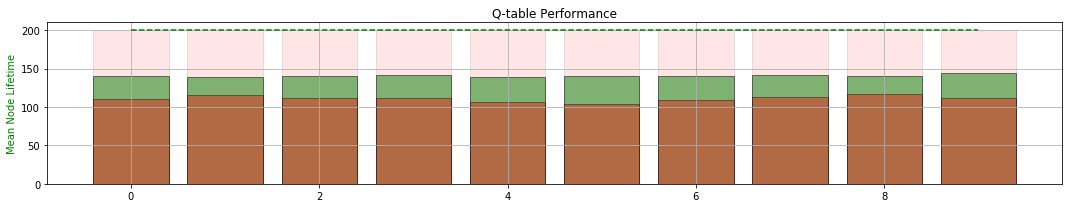

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 64.942	LOSS : 66.664	LOSS : 70.029	LOSS : 61.377	LOSS : 61.292	LOSS : 66.604	LOSS : 58.834	LOSS : 60.306	LOSS : 51.077	LOSS : 66.736	LOSS : 50.065	LOSS : 61.348	LOSS : 59.721	LOSS : 61.269	LOSS : 67.676	LOSS : 62.710	LOSS : 59.692	LOSS : 55.592	LOSS : 58.983	LOSS : 75.232	
Validating... MEAN TIME:  136.245
LOSS : 63.528	LOSS : 65.115	LOSS : 57.967	LOSS : 57.130	LOSS : 59.838	LOSS : 59.077	LOSS : 59.998	LOSS : 72.341	LOSS : 56.873	LOSS : 65.636	LOSS : 57.514	LOSS : 64.759	LOSS : 73.556	LOSS : 62.286	LOSS : 57.945	LOSS : 60.431	LOSS : 71.353	LOSS : 63.676	LOSS : 69.039	LOSS : 61.316	
Validating... MEAN TIME:  150.35
LOSS : 55.658	LOSS : 71.035	LOSS : 71.684	LOSS : 68.333	LOSS : 61.177	LOSS : 65.989	LOSS : 64.385	LOSS : 68.328	LOSS : 62.180	LOSS : 65.173	LOSS : 63.157	LOSS : 58.665	LOSS : 60.981	LOSS : 60.968	LOSS : 64.849	LOSS : 58.870	LOSS : 63.227	LOSS : 59.635	LOSS : 66.649	LOSS : 68.712	
Valida

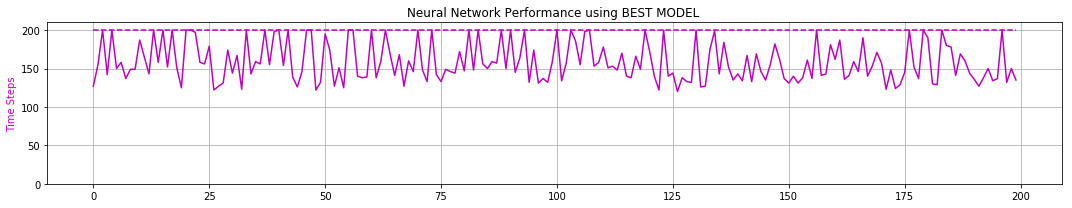

peak memory: 1486.82 MiB, increment: 1033.12 MiB
0 -max- [ 1.044  1.505  0.209  0.721]
0 -min- [-2.400 -2.774 -0.178 -0.885]

1 -max- [ 1.049  1.487  0.209  0.877]
1 -min- [-2.400 -2.707 -0.188 -0.796]

2 -max- [ 1.023  1.502  0.206  0.797]
2 -min- [-2.398 -2.693 -0.179 -0.797]

3 -max- [ 1.062  1.495  0.209  0.778]
3 -min- [-2.400 -2.591 -0.208 -0.862]

4 -max- [ 1.066  1.502  0.209  0.761]
4 -min- [-2.400 -2.705 -0.186 -0.769]

5 -max- [ 1.046  1.499  0.208  0.745]
5 -min- [-2.400 -2.739 -0.181 -0.804]

6 -max- [ 1.049  1.665  0.209  0.785]
6 -min- [-2.400 -2.732 -0.196 -1.018]

7 -max- [ 1.056  1.502  0.208  0.744]
7 -min- [-2.400 -2.735 -0.196 -0.811]

8 -max- [ 1.051  1.487  0.209  0.808]
8 -min- [-2.400 -2.720 -0.200 -0.914]

9 -max- [ 0.996  1.477  0.208  0.718]
9 -min- [-2.400 -2.574 -0.177 -0.783]

Quantization TIME:  0.02 minutes


ITERATION # 20
TOTAL EXPERIENCE GENERATED:   133526
SMALLEST TIMESTEP: 79
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   2184296
TOTAL PARALLEL 

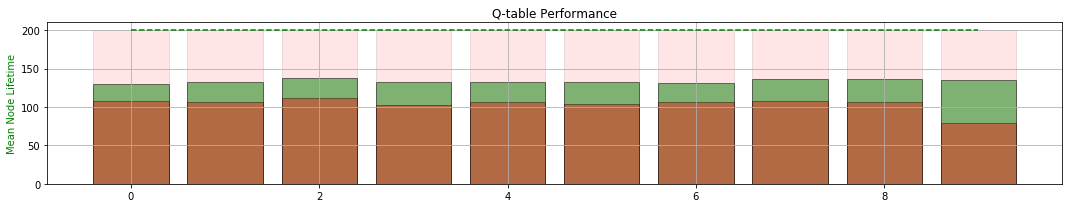

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 61.391	LOSS : 60.554	LOSS : 65.124	LOSS : 69.234	LOSS : 65.207	LOSS : 67.912	LOSS : 67.595	LOSS : 71.076	LOSS : 64.841	LOSS : 79.452	LOSS : 60.122	LOSS : 74.133	LOSS : 63.990	LOSS : 69.190	LOSS : 66.531	LOSS : 59.171	LOSS : 63.259	LOSS : 64.149	LOSS : 70.170	LOSS : 62.841	
Validating... MEAN TIME:  141.025
LOSS : 68.954	LOSS : 62.240	LOSS : 66.871	LOSS : 73.175	LOSS : 64.516	LOSS : 69.734	LOSS : 62.710	LOSS : 66.781	LOSS : 61.078	LOSS : 61.253	LOSS : 62.519	LOSS : 61.228	LOSS : 66.732	LOSS : 65.785	LOSS : 64.035	LOSS : 56.788	LOSS : 58.800	LOSS : 67.725	LOSS : 54.638	LOSS : 68.734	
Validating... MEAN TIME:  151.075
LOSS : 61.687	LOSS : 64.916	LOSS : 63.875	LOSS : 55.842	LOSS : 60.207	LOSS : 68.384	LOSS : 63.253	LOSS : 70.142	LOSS : 60.636	LOSS : 59.551	LOSS : 57.840	LOSS : 60.669	LOSS : 72.158	LOSS : 68.704	LOSS : 68.245	LOSS : 62.857	LOSS : 66.546	LOSS : 72.590	LOSS : 63.957	LOSS : 64.418	
Valid

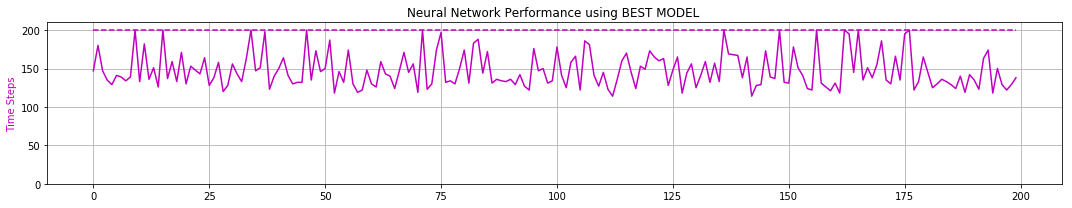

peak memory: 1451.67 MiB, increment: 1025.06 MiB
0 -max- [ 1.071  1.620  0.208  0.754]
0 -min- [-2.398 -2.926 -0.209 -0.993]

1 -max- [ 1.075  1.504  0.209  0.748]
1 -min- [-2.398 -2.780 -0.209 -0.905]

2 -max- [ 1.072  1.501  0.208  0.778]
2 -min- [-2.391 -2.938 -0.209 -0.832]

3 -max- [ 1.086  1.504  0.209  0.792]
3 -min- [-2.399 -2.875 -0.209 -0.810]

4 -max- [ 1.077  1.497  0.209  0.778]
4 -min- [-2.396 -2.949 -0.209 -0.822]

5 -max- [ 1.079  1.505  0.209  0.769]
5 -min- [-2.395 -2.938 -0.209 -0.810]

6 -max- [ 1.107  1.695  0.209  0.770]
6 -min- [-2.394 -2.781 -0.209 -0.817]

7 -max- [ 1.057  1.479  0.209  0.786]
7 -min- [-2.400 -2.902 -0.209 -0.829]

8 -max- [ 1.080  1.503  0.209  0.772]
8 -min- [-2.397 -2.873 -0.209 -0.820]

9 -max- [ 1.060  1.504  0.209  0.784]
9 -min- [-2.398 -2.875 -0.209 -0.784]

Quantization TIME:  0.01 minutes


ITERATION # 21
TOTAL EXPERIENCE GENERATED:   126508
SMALLEST TIMESTEP: 54
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   2310804
TOTAL PARALLEL 

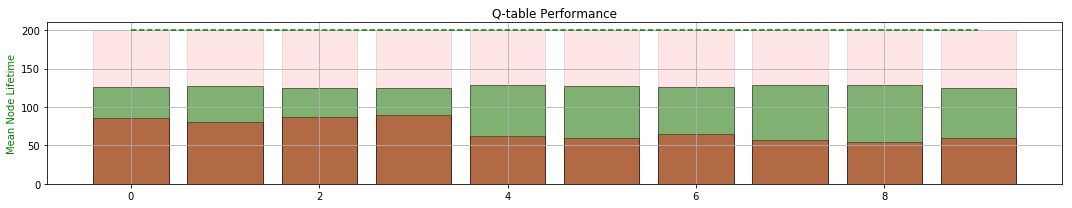

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 63.987	LOSS : 69.110	LOSS : 61.879	LOSS : 64.617	LOSS : 65.079	LOSS : 60.798	LOSS : 62.129	LOSS : 59.594	LOSS : 64.282	LOSS : 60.020	LOSS : 69.180	LOSS : 64.981	LOSS : 58.136	LOSS : 62.858	LOSS : 55.718	LOSS : 56.263	LOSS : 57.722	LOSS : 71.426	LOSS : 64.721	LOSS : 65.268	
Validating... MEAN TIME:  150.145
LOSS : 63.918	LOSS : 57.437	LOSS : 66.321	LOSS : 59.049	LOSS : 70.952	LOSS : 71.313	LOSS : 70.750	LOSS : 64.966	LOSS : 63.971	LOSS : 66.263	LOSS : 58.807	LOSS : 66.886	LOSS : 64.757	LOSS : 68.921	LOSS : 67.156	LOSS : 57.508	LOSS : 61.651	LOSS : 68.566	LOSS : 59.740	LOSS : 53.891	
Validating... MEAN TIME:  142.54
LOSS : 66.736	LOSS : 72.953	LOSS : 64.939	LOSS : 60.890	LOSS : 70.085	LOSS : 59.245	LOSS : 67.577	LOSS : 57.643	LOSS : 61.935	LOSS : 58.146	LOSS : 63.724	LOSS : 63.562	LOSS : 59.317	LOSS : 62.790	LOSS : 69.545	LOSS : 61.184	LOSS : 59.683	LOSS : 72.241	LOSS : 56.537	LOSS : 78.323	
Valida

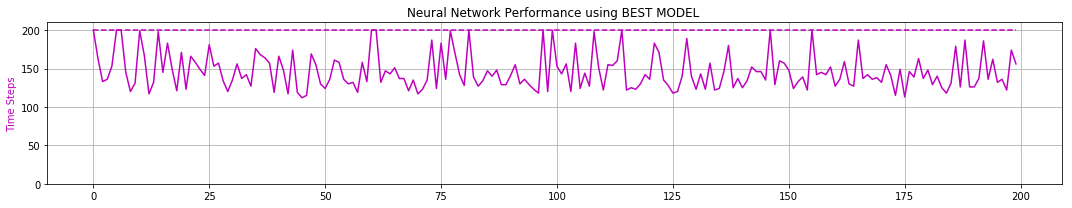

peak memory: 1457.33 MiB, increment: 982.92 MiB
0 -max- [ 1.122  1.656  0.209  0.738]
0 -min- [-2.394 -2.946 -0.209 -0.830]

1 -max- [ 1.124  1.677  0.209  0.740]
1 -min- [-2.388 -2.937 -0.209 -0.828]

2 -max- [ 1.154  1.664  0.209  0.714]
2 -min- [-2.397 -2.947 -0.209 -0.789]

3 -max- [ 1.151  1.602  0.209  0.791]
3 -min- [-2.397 -2.949 -0.209 -0.810]

4 -max- [ 1.151  1.503  0.208  0.686]
4 -min- [-2.395 -2.935 -0.209 -0.967]

5 -max- [ 1.191  1.631  0.209  0.769]
5 -min- [-2.399 -2.956 -0.209 -0.837]

6 -max- [ 1.130  1.612  0.209  0.797]
6 -min- [-2.399 -2.948 -0.209 -0.879]

7 -max- [ 1.096  1.601  0.208  0.755]
7 -min- [-2.387 -2.955 -0.209 -0.836]

8 -max- [ 1.176  1.683  0.209  0.718]
8 -min- [-2.400 -2.942 -0.209 -1.009]

9 -max- [ 1.188  1.673  0.209  0.634]
9 -min- [-2.394 -2.955 -0.209 -0.903]

Quantization TIME:  0.01 minutes


ITERATION # 22
TOTAL EXPERIENCE GENERATED:   130730
SMALLEST TIMESTEP: 61
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   2441534
TOTAL PARALLEL T

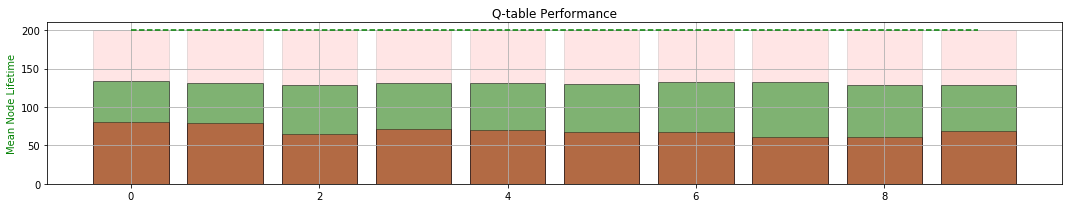

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 58.820	LOSS : 59.985	LOSS : 77.444	LOSS : 61.256	LOSS : 67.935	LOSS : 70.939	LOSS : 72.460	LOSS : 64.581	LOSS : 62.587	LOSS : 66.917	LOSS : 53.781	LOSS : 57.955	LOSS : 74.974	LOSS : 63.559	LOSS : 66.567	LOSS : 66.510	LOSS : 68.526	LOSS : 69.207	LOSS : 62.405	LOSS : 61.644	
Validating... MEAN TIME:  170.64
LOSS : 65.530	LOSS : 56.441	LOSS : 66.750	LOSS : 65.088	LOSS : 70.447	LOSS : 69.412	LOSS : 65.463	LOSS : 61.525	LOSS : 65.172	LOSS : 59.287	LOSS : 63.053	LOSS : 58.958	LOSS : 60.052	LOSS : 71.244	LOSS : 55.188	LOSS : 64.343	LOSS : 65.130	LOSS : 63.240	LOSS : 55.162	LOSS : 52.781	
Validating... MEAN TIME:  181.965
LOSS : 63.923	LOSS : 62.528	LOSS : 65.011	LOSS : 60.789	LOSS : 57.115	LOSS : 73.295	LOSS : 72.913	LOSS : 64.259	LOSS : 53.557	LOSS : 55.128	LOSS : 68.042	LOSS : 65.370	LOSS : 67.059	LOSS : 60.182	LOSS : 60.542	LOSS : 65.705	LOSS : 63.481	LOSS : 63.197	LOSS : 59.545	LOSS : 67.143	
Valida

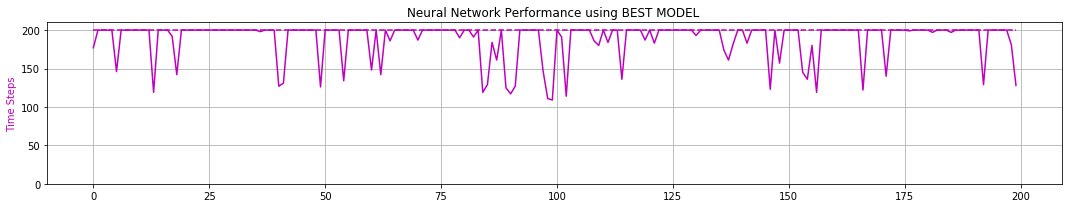

peak memory: 1497.54 MiB, increment: 1074.29 MiB
0 -max- [ 1.440  1.865  0.209  0.603]
0 -min- [-2.386 -2.965 -0.209 -0.836]

1 -max- [ 1.548  2.046  0.209  0.782]
1 -min- [-2.388 -2.954 -0.209 -0.789]

2 -max- [ 1.585  2.055  0.209  0.653]
2 -min- [-2.394 -2.941 -0.209 -0.796]

3 -max- [ 1.582  2.050  0.209  0.756]
3 -min- [-2.396 -3.128 -0.209 -0.785]

4 -max- [ 1.604  1.972  0.209  0.787]
4 -min- [-2.397 -3.063 -0.209 -0.853]

5 -max- [ 1.456  1.851  0.209  0.705]
5 -min- [-2.395 -2.962 -0.209 -0.797]

6 -max- [ 1.578  2.045  0.209  0.682]
6 -min- [-2.398 -2.957 -0.209 -0.760]

7 -max- [ 1.522  1.986  0.209  0.709]
7 -min- [-2.397 -2.970 -0.209 -1.041]

8 -max- [ 1.569  2.005  0.209  0.812]
8 -min- [-2.395 -2.954 -0.209 -1.000]

9 -max- [ 1.454  1.984  0.209  0.806]
9 -min- [-2.396 -2.958 -0.209 -1.038]

Quantization TIME:  0.01 minutes


ITERATION # 23
TOTAL EXPERIENCE GENERATED:   152567
SMALLEST TIMESTEP: 100
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   2594101
TOTAL PARALLEL

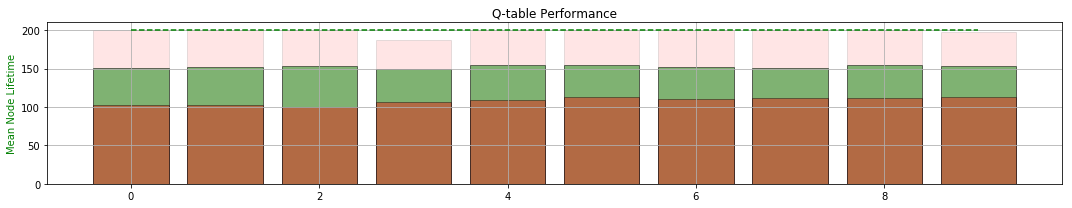

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 66.326	LOSS : 78.878	LOSS : 65.370	LOSS : 66.720	LOSS : 71.693	LOSS : 66.743	LOSS : 68.585	LOSS : 65.301	LOSS : 61.863	LOSS : 64.924	LOSS : 64.792	LOSS : 63.294	LOSS : 57.099	LOSS : 65.006	LOSS : 55.435	LOSS : 61.535	LOSS : 62.986	LOSS : 63.510	LOSS : 69.559	LOSS : 67.827	
Validating... MEAN TIME:  160.74
LOSS : 59.279	LOSS : 66.240	LOSS : 59.912	LOSS : 63.200	LOSS : 60.346	LOSS : 58.940	LOSS : 62.436	LOSS : 68.271	LOSS : 67.038	LOSS : 64.696	LOSS : 61.174	LOSS : 69.353	LOSS : 66.570	LOSS : 71.239	LOSS : 57.883	LOSS : 58.950	LOSS : 59.685	LOSS : 69.492	LOSS : 63.243	LOSS : 59.359	
Validating... MEAN TIME:  165.39
LOSS : 67.446	LOSS : 63.112	LOSS : 68.590	LOSS : 61.529	LOSS : 74.197	LOSS : 56.899	LOSS : 71.580	LOSS : 61.111	LOSS : 56.768	LOSS : 70.636	LOSS : 63.806	LOSS : 67.132	LOSS : 54.952	LOSS : 60.028	LOSS : 57.767	LOSS : 61.848	LOSS : 55.135	LOSS : 54.902	LOSS : 64.098	LOSS : 62.683	
Validat

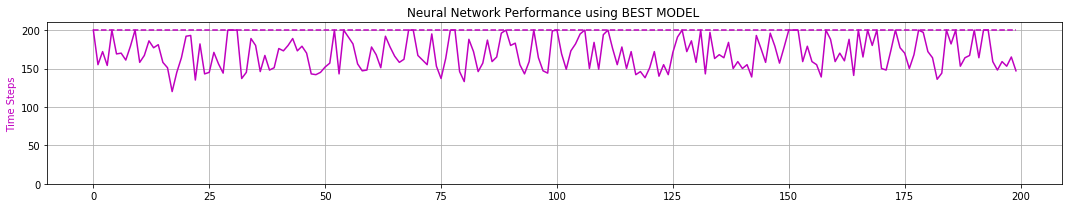

peak memory: 1461.22 MiB, increment: 978.54 MiB
0 -max- [ 1.398  1.986  0.209  0.796]
0 -min- [-2.399 -1.994 -0.135 -0.727]

1 -max- [ 1.417  1.954  0.209  0.774]
1 -min- [-2.400 -2.077 -0.134 -0.744]

2 -max- [ 1.445  1.994  0.209  0.870]
2 -min- [-2.400 -2.198 -0.136 -0.797]

3 -max- [ 1.453  2.034  0.209  0.805]
3 -min- [-2.400 -1.989 -0.142 -0.782]

4 -max- [ 1.460  1.869  0.209  0.758]
4 -min- [-2.399 -2.063 -0.136 -0.708]

5 -max- [ 1.463  2.003  0.209  0.677]
5 -min- [-2.400 -2.071 -0.156 -0.745]

6 -max- [ 1.465  1.983  0.209  0.758]
6 -min- [-2.399 -2.063 -0.175 -0.875]

7 -max- [ 1.441  2.059  0.209  0.794]
7 -min- [-2.400 -2.198 -0.158 -0.731]

8 -max- [ 1.411  1.861  0.209  0.795]
8 -min- [-2.400 -2.062 -0.143 -0.790]

9 -max- [ 1.474  1.974  0.209  0.755]
9 -min- [-2.400 -1.981 -0.139 -0.747]

Quantization TIME:  0.01 minutes


ITERATION # 24
TOTAL EXPERIENCE GENERATED:   149576
SMALLEST TIMESTEP: 98
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   2743677
TOTAL PARALLEL T

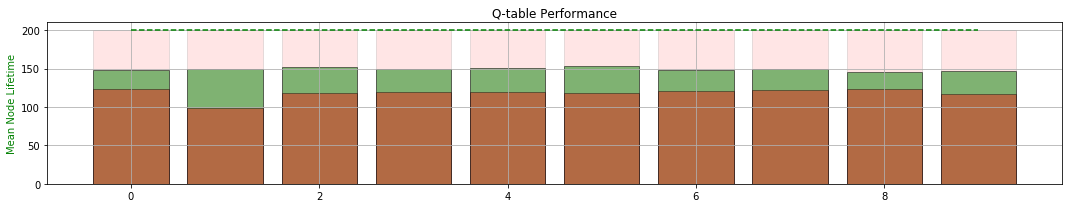

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 63.824	LOSS : 56.000	LOSS : 44.658	LOSS : 51.092	LOSS : 52.897	LOSS : 59.525	LOSS : 56.880	LOSS : 51.274	LOSS : 55.909	LOSS : 61.918	LOSS : 61.426	LOSS : 55.951	LOSS : 58.212	LOSS : 60.622	LOSS : 57.026	LOSS : 53.062	LOSS : 62.214	LOSS : 56.661	LOSS : 51.350	LOSS : 49.347	
Validating... MEAN TIME:  170.645
LOSS : 56.987	LOSS : 50.245	LOSS : 57.566	LOSS : 52.921	LOSS : 62.144	LOSS : 61.644	LOSS : 56.503	LOSS : 55.529	LOSS : 58.075	LOSS : 59.125	LOSS : 51.214	LOSS : 57.719	LOSS : 66.323	LOSS : 47.033	LOSS : 67.525	LOSS : 64.519	LOSS : 51.225	LOSS : 61.916	LOSS : 51.039	LOSS : 57.258	
Validating... MEAN TIME:  166.11
LOSS : 66.054	LOSS : 52.830	LOSS : 56.392	LOSS : 58.940	LOSS : 62.976	LOSS : 60.750	LOSS : 54.040	LOSS : 60.466	LOSS : 55.241	LOSS : 63.086	LOSS : 59.050	LOSS : 66.389	LOSS : 51.102	LOSS : 63.475	LOSS : 61.570	LOSS : 62.998	LOSS : 54.290	LOSS : 55.828	LOSS : 65.575	LOSS : 62.478	
Valida

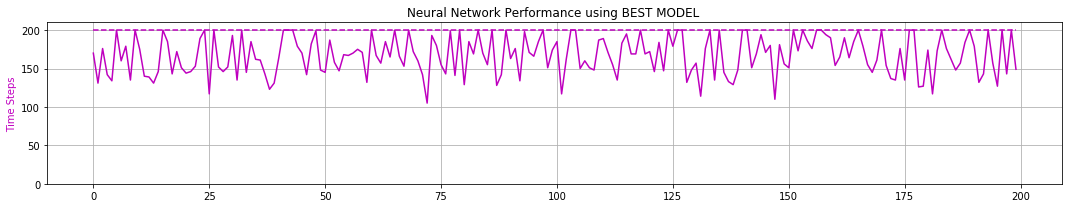

peak memory: 1482.14 MiB, increment: 1074.01 MiB
0 -max- [ 1.377  1.680  0.209  0.763]
0 -min- [-2.400 -2.556 -0.164 -0.787]

1 -max- [ 1.491  1.870  0.209  0.935]
1 -min- [-2.400 -2.611 -0.202 -1.130]

2 -max- [ 1.451  1.831  0.209  0.745]
2 -min- [-2.399 -2.588 -0.166 -0.787]

3 -max- [ 1.485  1.986  0.209  0.762]
3 -min- [-2.400 -2.526 -0.174 -0.838]

4 -max- [ 1.449  1.820  0.209  0.683]
4 -min- [-2.399 -2.598 -0.166 -0.802]

5 -max- [ 1.492  1.836  0.208  0.782]
5 -min- [-2.399 -2.615 -0.166 -0.844]

6 -max- [ 1.389  1.695  0.208  0.932]
6 -min- [-2.399 -2.539 -0.190 -0.954]

7 -max- [ 1.372  1.666  0.208  0.714]
7 -min- [-2.400 -2.562 -0.178 -0.869]

8 -max- [ 1.454  1.797  0.209  0.685]
8 -min- [-2.400 -2.597 -0.170 -0.781]

9 -max- [ 1.457  1.867  0.209  0.726]
9 -min- [-2.400 -2.433 -0.163 -0.765]

Quantization TIME:  0.01 minutes


ITERATION # 25
TOTAL EXPERIENCE GENERATED:   160110
SMALLEST TIMESTEP: 100
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   2903787
TOTAL PARALLEL

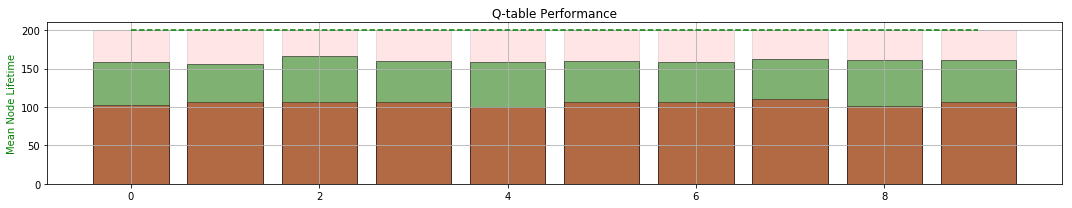

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 57.467	LOSS : 48.993	LOSS : 51.196	LOSS : 57.314	LOSS : 48.182	LOSS : 61.725	LOSS : 47.054	LOSS : 54.714	LOSS : 56.959	LOSS : 57.949	LOSS : 46.166	LOSS : 49.770	LOSS : 55.961	LOSS : 58.338	LOSS : 48.142	LOSS : 53.377	LOSS : 56.942	LOSS : 49.956	LOSS : 49.991	LOSS : 63.229	
Validating... MEAN TIME:  182.54
LOSS : 50.097	LOSS : 54.888	LOSS : 46.513	LOSS : 57.796	LOSS : 59.728	LOSS : 52.548	LOSS : 55.994	LOSS : 56.828	LOSS : 50.584	LOSS : 55.186	LOSS : 45.760	LOSS : 66.170	LOSS : 54.341	LOSS : 56.212	LOSS : 48.688	LOSS : 50.259	LOSS : 60.649	LOSS : 56.198	LOSS : 54.352	LOSS : 50.663	
Validating... MEAN TIME:  188.705
LOSS : 52.894	LOSS : 54.310	LOSS : 61.561	LOSS : 51.061	LOSS : 43.541	LOSS : 52.699	LOSS : 48.255	LOSS : 51.357	LOSS : 52.190	LOSS : 57.462	LOSS : 54.984	LOSS : 49.782	LOSS : 57.116	LOSS : 53.681	LOSS : 55.074	LOSS : 49.995	LOSS : 57.118	LOSS : 47.862	LOSS : 56.208	LOSS : 51.460	
Valida

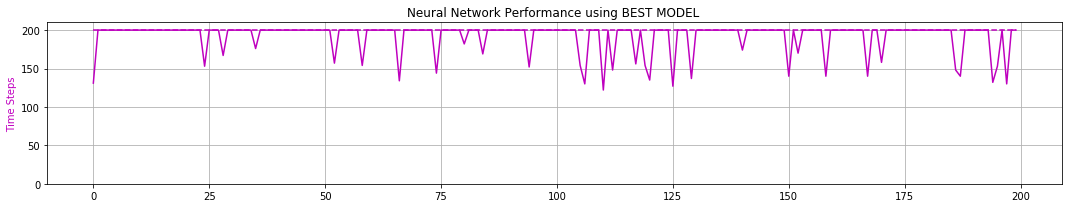

peak memory: 1473.82 MiB, increment: 1005.86 MiB
0 -max- [ 1.338  1.867  0.209  0.812]
0 -min- [-2.400 -2.783 -0.195 -0.810]

1 -max- [ 1.358  1.979  0.209  1.013]
1 -min- [-2.399 -2.807 -0.196 -0.820]

2 -max- [ 1.305  1.864  0.209  0.793]
2 -min- [-2.400 -2.803 -0.193 -0.821]

3 -max- [ 1.320  1.838  0.209  0.799]
3 -min- [-2.400 -2.785 -0.187 -0.787]

4 -max- [ 1.350  1.993  0.209  1.138]
4 -min- [-2.399 -2.786 -0.209 -1.039]

5 -max- [ 1.329  1.862  0.209  1.065]
5 -min- [-2.398 -2.776 -0.185 -0.802]

6 -max- [ 1.344  1.860  0.209  0.783]
6 -min- [-2.400 -2.807 -0.205 -0.957]

7 -max- [ 1.363  1.959  0.209  0.793]
7 -min- [-2.399 -2.780 -0.193 -0.877]

8 -max- [ 1.323  1.879  0.209  1.080]
8 -min- [-2.397 -2.797 -0.188 -0.816]

9 -max- [ 1.319  1.875  0.209  0.828]
9 -min- [-2.399 -2.805 -0.188 -0.856]

Quantization TIME:  0.01 minutes


ITERATION # 26
TOTAL EXPERIENCE GENERATED:   193930
SMALLEST TIMESTEP: 125
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   3097717
TOTAL PARALLEL

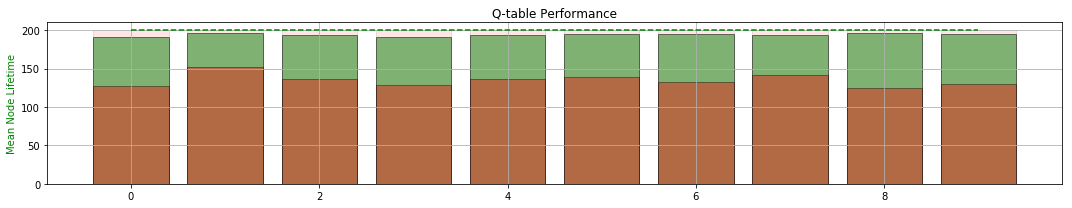

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 49.834	LOSS : 50.201	LOSS : 58.690	LOSS : 56.598	LOSS : 60.754	LOSS : 60.875	LOSS : 55.850	LOSS : 50.224	LOSS : 51.015	LOSS : 52.014	LOSS : 53.504	LOSS : 46.606	LOSS : 57.198	LOSS : 59.043	LOSS : 37.672	LOSS : 44.080	LOSS : 52.829	LOSS : 42.168	LOSS : 49.066	LOSS : 57.260	
Validating... MEAN TIME:  175.325
LOSS : 52.838	LOSS : 47.195	LOSS : 50.120	LOSS : 46.121	LOSS : 47.012	LOSS : 48.517	LOSS : 52.192	LOSS : 47.170	LOSS : 50.997	LOSS : 42.787	LOSS : 52.394	LOSS : 53.738	LOSS : 44.448	LOSS : 50.126	LOSS : 57.883	LOSS : 45.112	LOSS : 45.938	LOSS : 47.708	LOSS : 58.546	LOSS : 56.238	
Validating... MEAN TIME:  141.72
LOSS : 46.049	LOSS : 46.025	LOSS : 51.905	LOSS : 44.459	LOSS : 53.952	LOSS : 48.558	LOSS : 48.386	LOSS : 54.686	LOSS : 47.571	LOSS : 45.479	LOSS : 56.084	LOSS : 52.052	LOSS : 57.889	LOSS : 41.316	LOSS : 47.141	LOSS : 53.310	LOSS : 59.076	LOSS : 42.386	LOSS : 45.808	LOSS : 51.033	
Valida

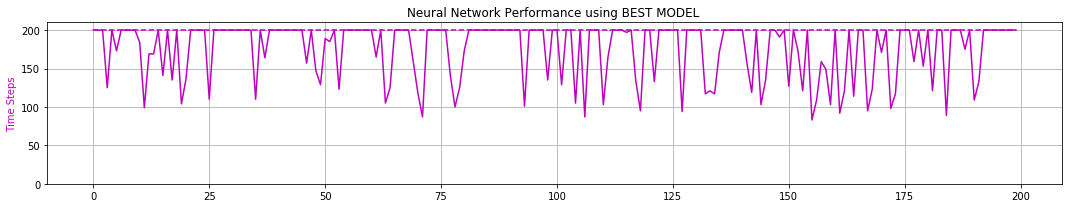

peak memory: 1456.50 MiB, increment: 1036.87 MiB
0 -max- [ 1.409  1.861  0.209  0.808]
0 -min- [-1.726 -1.169 -0.073 -0.713]

1 -max- [ 1.367  1.664  0.209  0.774]
1 -min- [-1.736 -1.163 -0.079 -0.976]

2 -max- [ 1.452  1.695  0.209  0.772]
2 -min- [-1.749 -1.116 -0.078 -0.709]

3 -max- [ 1.469  1.870  0.209  1.037]
3 -min- [-1.752 -1.326 -0.093 -0.949]

4 -max- [ 1.392  1.697  0.209  0.996]
4 -min- [-1.746 -1.342 -0.110 -1.051]

5 -max- [ 1.432  1.695  0.209  0.793]
5 -min- [-1.746 -1.148 -0.079 -0.833]

6 -max- [ 1.441  1.700  0.209  0.779]
6 -min- [-1.738 -1.168 -0.073 -0.735]

7 -max- [ 1.378  1.695  0.209  0.765]
7 -min- [-1.768 -1.136 -0.069 -0.933]

8 -max- [ 1.406  1.686  0.209  0.745]
8 -min- [-1.720 -1.170 -0.077 -0.761]

9 -max- [ 1.398  1.690  0.209  1.110]
9 -min- [-1.746 -1.148 -0.087 -0.715]

Quantization TIME:  0.01 minutes


ITERATION # 27
TOTAL EXPERIENCE GENERATED:   119964
SMALLEST TIMESTEP: 67
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   3217681
TOTAL PARALLEL 

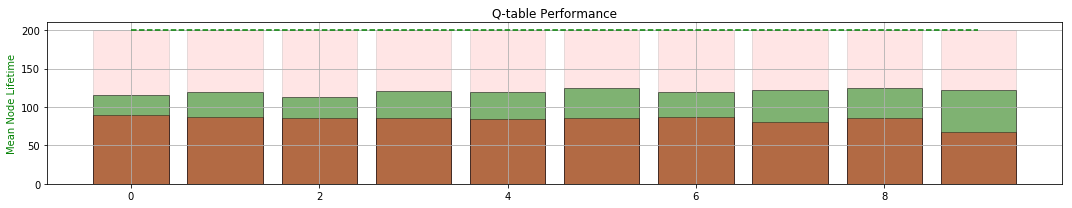

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 59.436	LOSS : 74.195	LOSS : 64.162	LOSS : 66.312	LOSS : 71.896	LOSS : 64.961	LOSS : 64.447	LOSS : 60.002	LOSS : 73.981	LOSS : 64.097	LOSS : 66.140	LOSS : 69.391	LOSS : 55.207	LOSS : 65.782	LOSS : 73.876	LOSS : 57.711	LOSS : 55.533	LOSS : 69.206	LOSS : 69.778	LOSS : 71.509	
Validating... MEAN TIME:  170.995
LOSS : 63.385	LOSS : 67.908	LOSS : 58.290	LOSS : 64.277	LOSS : 61.654	LOSS : 74.082	LOSS : 68.185	LOSS : 69.706	LOSS : 64.613	LOSS : 69.604	LOSS : 73.481	LOSS : 67.102	LOSS : 65.919	LOSS : 69.957	LOSS : 70.303	LOSS : 68.835	LOSS : 69.797	LOSS : 59.565	LOSS : 63.312	LOSS : 67.317	
Validating... MEAN TIME:  177.285
LOSS : 53.889	LOSS : 76.235	LOSS : 60.104	LOSS : 67.078	LOSS : 65.887	LOSS : 69.648	LOSS : 62.535	LOSS : 57.722	LOSS : 69.413	LOSS : 62.681	LOSS : 71.221	LOSS : 63.764	LOSS : 56.857	LOSS : 72.422	LOSS : 57.346	LOSS : 56.598	LOSS : 73.256	LOSS : 68.422	LOSS : 64.994	LOSS : 59.715	
Valid

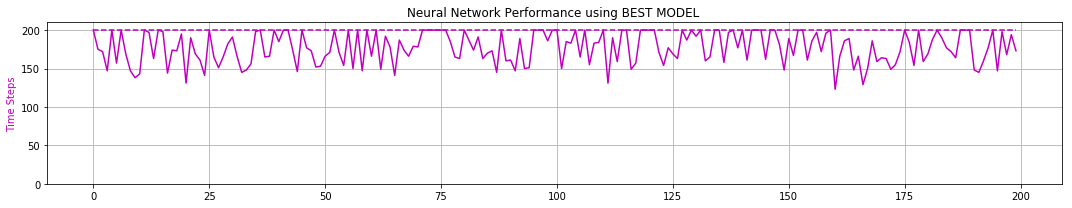

peak memory: 1464.03 MiB, increment: 986.14 MiB
0 -max- [ 1.204  1.984  0.209  0.808]
0 -min- [-2.313 -1.824 -0.128 -0.737]

1 -max- [ 1.200  1.957  0.209  1.064]
1 -min- [-2.326 -2.036 -0.111 -0.599]

2 -max- [ 1.240  2.035  0.209  0.958]
2 -min- [-2.320 -1.876 -0.133 -0.739]

3 -max- [ 1.315  2.056  0.209  0.861]
3 -min- [-2.337 -1.848 -0.108 -0.672]

4 -max- [ 1.206  1.977  0.209  1.126]
4 -min- [-2.351 -1.851 -0.118 -1.159]

5 -max- [ 1.227  1.968  0.209  0.989]
5 -min- [-2.321 -1.842 -0.122 -0.722]

6 -max- [ 1.199  1.971  0.209  0.922]
6 -min- [-2.329 -1.844 -0.118 -0.683]

7 -max- [ 1.205  1.971  0.209  0.899]
7 -min- [-2.330 -1.878 -0.139 -0.958]

8 -max- [ 1.228  1.979  0.209  0.994]
8 -min- [-2.351 -1.888 -0.118 -0.821]

9 -max- [ 1.207  1.984  0.209  0.882]
9 -min- [-2.335 -1.879 -0.116 -0.667]

Quantization TIME:  0.02 minutes


ITERATION # 28
TOTAL EXPERIENCE GENERATED:   171378
SMALLEST TIMESTEP: 108
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   3389059
TOTAL PARALLEL 

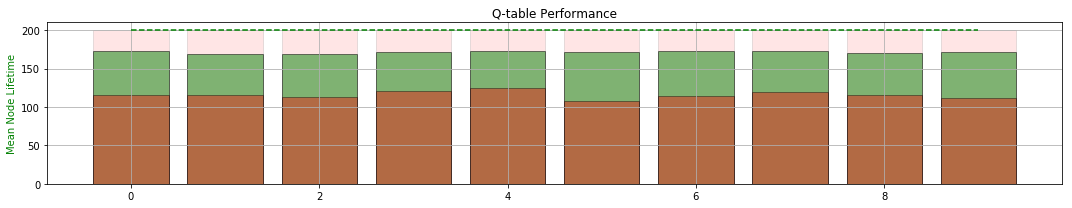

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 54.352	LOSS : 55.840	LOSS : 67.737	LOSS : 54.605	LOSS : 60.556	LOSS : 61.673	LOSS : 55.768	LOSS : 56.597	LOSS : 54.640	LOSS : 69.144	LOSS : 60.126	LOSS : 60.282	LOSS : 53.743	LOSS : 57.685	LOSS : 59.663	LOSS : 59.047	LOSS : 55.871	LOSS : 56.143	LOSS : 58.047	LOSS : 59.564	
Validating... MEAN TIME:  139.6
LOSS : 60.741	LOSS : 63.786	LOSS : 49.798	LOSS : 56.997	LOSS : 59.152	LOSS : 59.441	LOSS : 51.916	LOSS : 58.391	LOSS : 60.534	LOSS : 53.600	LOSS : 65.213	LOSS : 57.210	LOSS : 53.877	LOSS : 53.007	LOSS : 60.721	LOSS : 56.977	LOSS : 56.726	LOSS : 54.108	LOSS : 52.546	LOSS : 56.383	
Validating... MEAN TIME:  158.565
LOSS : 56.154	LOSS : 57.741	LOSS : 49.340	LOSS : 60.962	LOSS : 60.494	LOSS : 54.560	LOSS : 60.923	LOSS : 54.073	LOSS : 55.554	LOSS : 53.642	LOSS : 57.831	LOSS : 52.477	LOSS : 51.157	LOSS : 52.849	LOSS : 53.606	LOSS : 61.641	LOSS : 53.125	LOSS : 53.112	LOSS : 62.357	LOSS : 51.987	
Validat

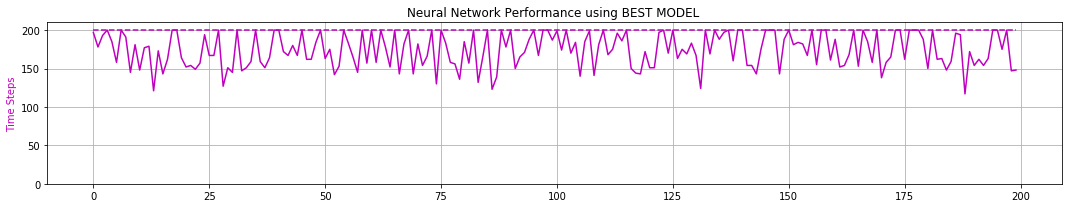

peak memory: 1471.32 MiB, increment: 1037.14 MiB
0 -max- [ 1.437  1.876  0.209  1.401]
0 -min- [-2.400 -2.756 -0.139 -0.761]

1 -max- [ 1.399  1.876  0.209  1.689]
1 -min- [-2.398 -2.849 -0.155 -0.771]

2 -max- [ 1.415  1.986  0.209  1.410]
2 -min- [-2.399 -2.830 -0.167 -1.039]

3 -max- [ 1.438  1.873  0.209  1.608]
3 -min- [-2.400 -2.969 -0.151 -0.784]

4 -max- [ 1.400  1.883  0.209  1.412]
4 -min- [-2.399 -2.812 -0.159 -0.787]

5 -max- [ 1.395  1.878  0.209  1.411]
5 -min- [-2.400 -2.760 -0.150 -0.794]

6 -max- [ 1.367  1.873  0.209  1.673]
6 -min- [-2.400 -2.940 -0.147 -0.789]

7 -max- [ 1.381  1.880  0.209  1.487]
7 -min- [-2.399 -2.801 -0.149 -0.962]

8 -max- [ 1.353  1.805  0.209  1.390]
8 -min- [-2.399 -2.764 -0.165 -1.049]

9 -max- [ 1.369  1.879  0.209  1.401]
9 -min- [-2.394 -2.751 -0.174 -0.908]

Quantization TIME:  0.01 minutes


ITERATION # 29
TOTAL EXPERIENCE GENERATED:   162995
SMALLEST TIMESTEP: 107
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   3552054
TOTAL PARALLEL

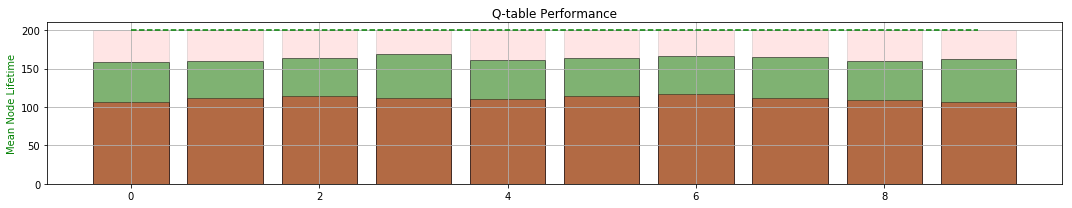

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 59.474	LOSS : 52.861	LOSS : 53.334	LOSS : 53.891	LOSS : 48.687	LOSS : 56.737	LOSS : 63.552	LOSS : 65.004	LOSS : 50.319	LOSS : 59.647	LOSS : 62.127	LOSS : 48.093	LOSS : 48.924	LOSS : 47.134	LOSS : 50.247	LOSS : 55.610	LOSS : 52.690	LOSS : 46.771	LOSS : 53.402	LOSS : 55.647	
Validating... MEAN TIME:  176.76
LOSS : 49.397	LOSS : 58.040	LOSS : 57.825	LOSS : 49.448	LOSS : 53.092	LOSS : 53.161	LOSS : 49.588	LOSS : 56.685	LOSS : 56.112	LOSS : 53.418	LOSS : 63.064	LOSS : 58.365	LOSS : 56.612	LOSS : 49.334	LOSS : 59.722	LOSS : 51.822	LOSS : 62.269	LOSS : 54.814	LOSS : 49.216	LOSS : 54.240	
Validating... MEAN TIME:  162.85
LOSS : 52.713	LOSS : 44.837	LOSS : 57.975	LOSS : 50.369	LOSS : 53.490	LOSS : 56.763	LOSS : 59.626	LOSS : 57.135	LOSS : 55.954	LOSS : 52.459	LOSS : 47.040	LOSS : 56.103	LOSS : 55.752	LOSS : 47.916	LOSS : 51.003	LOSS : 57.228	LOSS : 54.047	LOSS : 50.924	LOSS : 43.830	LOSS : 53.780	
Validat

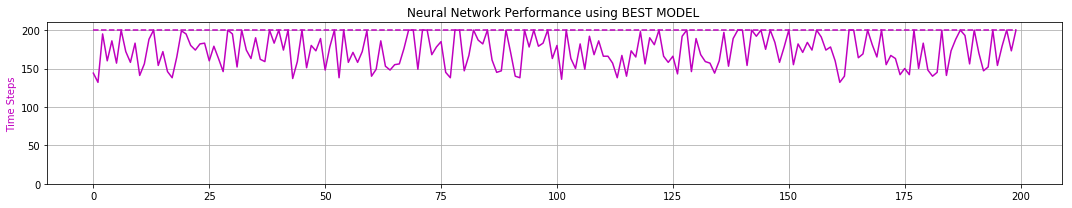

peak memory: 1475.78 MiB, increment: 982.89 MiB
0 -max- [ 1.489  1.883  0.209  1.241]
0 -min- [-2.398 -2.627 -0.162 -0.961]

1 -max- [ 1.502  2.002  0.209  1.315]
1 -min- [-2.398 -2.628 -0.185 -0.983]

2 -max- [ 1.476  1.974  0.209  1.120]
2 -min- [-2.397 -2.628 -0.163 -0.819]

3 -max- [ 1.463  1.876  0.209  0.972]
3 -min- [-2.398 -2.598 -0.163 -0.870]

4 -max- [ 1.508  1.990  0.209  1.002]
4 -min- [-2.397 -2.627 -0.188 -0.879]

5 -max- [ 1.496  1.912  0.209  1.086]
5 -min- [-2.400 -2.774 -0.185 -1.307]

6 -max- [ 1.529  2.051  0.209  1.023]
6 -min- [-2.399 -2.610 -0.164 -0.989]

7 -max- [ 1.509  2.004  0.209  1.034]
7 -min- [-2.399 -2.630 -0.183 -0.950]

8 -max- [ 1.470  1.971  0.209  1.093]
8 -min- [-2.395 -2.633 -0.168 -0.854]

9 -max- [ 1.490  1.875  0.209  1.196]
9 -min- [-2.397 -2.620 -0.167 -0.995]

Quantization TIME:  0.01 minutes


ITERATION # 30
TOTAL EXPERIENCE GENERATED:   168755
SMALLEST TIMESTEP: 113
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   3720809
TOTAL PARALLEL 

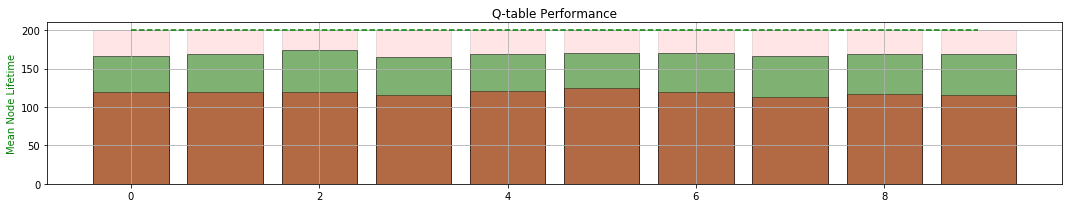

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 44.459	LOSS : 57.492	LOSS : 57.846	LOSS : 50.016	LOSS : 48.280	LOSS : 53.210	LOSS : 44.956	LOSS : 54.804	LOSS : 57.090	LOSS : 58.704	LOSS : 48.889	LOSS : 53.417	LOSS : 53.107	LOSS : 49.349	LOSS : 54.316	LOSS : 60.579	LOSS : 45.668	LOSS : 53.651	LOSS : 48.878	LOSS : 56.095	
Validating... MEAN TIME:  158.91
LOSS : 50.555	LOSS : 52.799	LOSS : 44.187	LOSS : 43.005	LOSS : 54.887	LOSS : 53.241	LOSS : 56.340	LOSS : 52.281	LOSS : 52.324	LOSS : 52.105	LOSS : 44.727	LOSS : 51.839	LOSS : 48.587	LOSS : 52.909	LOSS : 45.998	LOSS : 58.725	LOSS : 60.399	LOSS : 50.375	LOSS : 53.896	LOSS : 56.864	
Validating... MEAN TIME:  165.145
LOSS : 65.841	LOSS : 60.348	LOSS : 50.893	LOSS : 53.080	LOSS : 52.875	LOSS : 44.261	LOSS : 61.286	LOSS : 57.815	LOSS : 59.689	LOSS : 50.838	LOSS : 49.532	LOSS : 53.691	LOSS : 52.685	LOSS : 44.623	LOSS : 45.504	LOSS : 51.371	LOSS : 50.210	LOSS : 42.988	LOSS : 53.309	LOSS : 59.551	
Valida

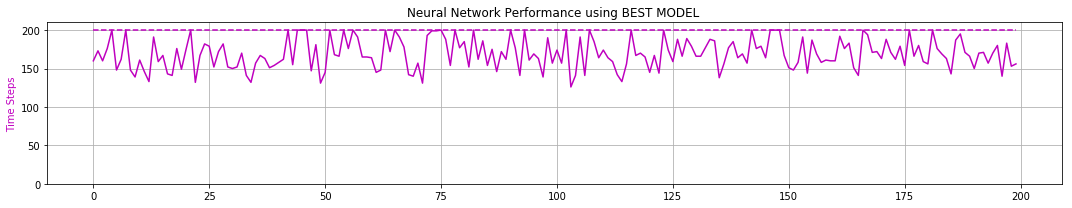

peak memory: 1505.97 MiB, increment: 978.31 MiB
0 -max- [ 1.668  2.194  0.209  1.117]
0 -min- [-2.398 -2.814 -0.183 -1.098]

1 -max- [ 1.671  2.038  0.209  1.136]
1 -min- [-2.398 -2.725 -0.172 -0.945]

2 -max- [ 1.630  2.053  0.209  1.035]
2 -min- [-2.396 -2.738 -0.158 -0.853]

3 -max- [ 1.650  2.005  0.209  1.065]
3 -min- [-2.398 -2.761 -0.165 -0.849]

4 -max- [ 1.665  2.168  0.209  1.075]
4 -min- [-2.394 -2.743 -0.169 -0.995]

5 -max- [ 1.704  2.155  0.209  0.972]
5 -min- [-2.397 -2.728 -0.164 -0.842]

6 -max- [ 1.661  2.004  0.209  1.024]
6 -min- [-2.393 -2.729 -0.181 -0.991]

7 -max- [ 1.642  2.231  0.209  1.095]
7 -min- [-2.398 -2.739 -0.169 -1.000]

8 -max- [ 1.649  2.177  0.209  1.101]
8 -min- [-2.395 -2.720 -0.191 -0.855]

9 -max- [ 1.757  2.156  0.209  0.853]
9 -min- [-2.399 -2.624 -0.164 -0.995]

Quantization TIME:  0.01 minutes


ITERATION # 31
TOTAL EXPERIENCE GENERATED:   179627
SMALLEST TIMESTEP: 112
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   3900436
TOTAL PARALLEL 

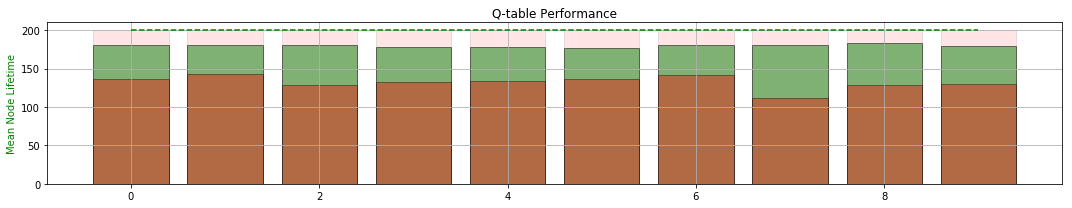

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 51.943	LOSS : 49.403	LOSS : 46.320	LOSS : 59.763	LOSS : 56.794	LOSS : 49.551	LOSS : 55.530	LOSS : 50.654	LOSS : 45.993	LOSS : 59.649	LOSS : 53.701	LOSS : 45.069	LOSS : 53.596	LOSS : 49.914	LOSS : 53.338	LOSS : 58.936	LOSS : 56.898	LOSS : 47.107	LOSS : 52.333	LOSS : 52.996	
Validating... MEAN TIME:  171.645
LOSS : 55.706	LOSS : 49.845	LOSS : 48.741	LOSS : 50.877	LOSS : 55.690	LOSS : 47.968	LOSS : 52.403	LOSS : 50.294	LOSS : 57.616	LOSS : 49.715	LOSS : 47.452	LOSS : 58.421	LOSS : 44.738	LOSS : 50.831	LOSS : 54.697	LOSS : 56.294	LOSS : 45.095	LOSS : 49.017	LOSS : 47.781	LOSS : 48.367	
Validating... MEAN TIME:  174.765
LOSS : 47.869	LOSS : 41.013	LOSS : 50.722	LOSS : 51.183	LOSS : 57.839	LOSS : 50.265	LOSS : 53.262	LOSS : 45.899	LOSS : 44.711	LOSS : 45.609	LOSS : 39.536	LOSS : 47.709	LOSS : 57.851	LOSS : 59.067	LOSS : 49.429	LOSS : 47.116	LOSS : 50.445	LOSS : 48.825	LOSS : 45.163	LOSS : 54.940	
Valid

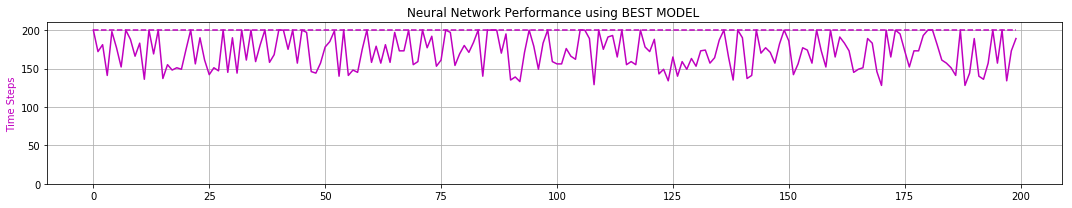

peak memory: 1525.50 MiB, increment: 978.19 MiB
0 -max- [ 2.397  2.427  0.208  1.267]
0 -min- [-2.400 -2.794 -0.195 -1.149]

1 -max- [ 2.268  2.424  0.208  1.078]
1 -min- [-2.398 -2.954 -0.205 -1.109]

2 -max- [ 2.280  2.404  0.209  0.984]
2 -min- [-2.399 -2.795 -0.207 -0.882]

3 -max- [ 2.322  2.429  0.209  1.098]
3 -min- [-2.400 -2.885 -0.206 -1.062]

4 -max- [ 2.372  2.399  0.209  1.097]
4 -min- [-2.398 -2.931 -0.198 -0.928]

5 -max- [ 2.393  2.395  0.209  0.924]
5 -min- [-2.400 -2.896 -0.207 -1.070]

6 -max- [ 2.372  2.424  0.209  0.937]
6 -min- [-2.395 -2.792 -0.209 -0.870]

7 -max- [ 1.994  2.039  0.209  0.999]
7 -min- [-2.398 -2.906 -0.204 -1.078]

8 -max- [ 2.275  2.435  0.208  1.102]
8 -min- [-2.400 -2.897 -0.203 -0.906]

9 -max- [ 2.270  2.397  0.209  0.996]
9 -min- [-2.400 -2.793 -0.200 -1.076]

Quantization TIME:  0.01 minutes


ITERATION # 32
TOTAL EXPERIENCE GENERATED:   163742
SMALLEST TIMESTEP: 102
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   4064178
TOTAL PARALLEL 

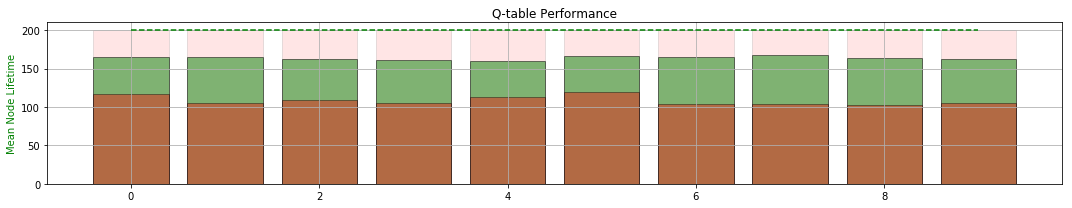

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 58.984	LOSS : 60.654	LOSS : 59.934	LOSS : 60.563	LOSS : 53.677	LOSS : 53.122	LOSS : 53.430	LOSS : 57.898	LOSS : 53.805	LOSS : 62.921	LOSS : 56.801	LOSS : 58.584	LOSS : 55.594	LOSS : 50.339	LOSS : 62.750	LOSS : 60.592	LOSS : 65.009	LOSS : 54.516	LOSS : 57.335	LOSS : 50.825	
Validating... MEAN TIME:  177.3
LOSS : 52.499	LOSS : 52.550	LOSS : 54.073	LOSS : 52.860	LOSS : 54.517	LOSS : 52.343	LOSS : 53.920	LOSS : 56.229	LOSS : 64.564	LOSS : 50.513	LOSS : 62.429	LOSS : 53.724	LOSS : 60.844	LOSS : 64.359	LOSS : 57.403	LOSS : 53.883	LOSS : 55.849	LOSS : 54.924	LOSS : 53.577	LOSS : 51.621	
Validating... MEAN TIME:  192.515
LOSS : 57.199	LOSS : 52.692	LOSS : 64.404	LOSS : 57.365	LOSS : 55.995	LOSS : 55.421	LOSS : 53.849	LOSS : 55.792	LOSS : 62.784	LOSS : 54.712	LOSS : 54.425	LOSS : 57.448	LOSS : 51.817	LOSS : 58.449	LOSS : 62.490	LOSS : 51.589	LOSS : 57.009	LOSS : 63.176	LOSS : 61.412	LOSS : 62.289	
Validat

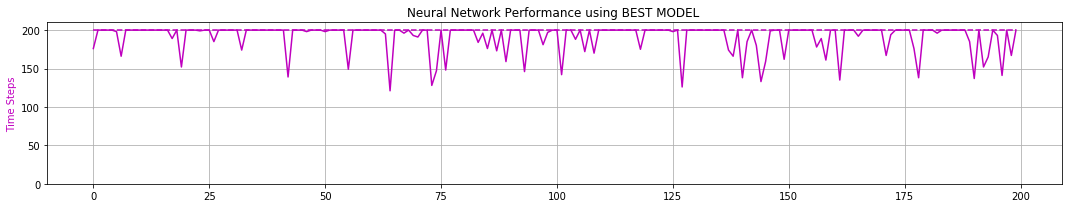

peak memory: 1494.07 MiB, increment: 1017.86 MiB
0 -max- [ 2.388  2.770  0.209  1.245]
0 -min- [-2.042 -2.610 -0.209 -0.922]

1 -max- [ 2.399  2.611  0.209  1.052]
1 -min- [-2.074 -2.595 -0.209 -1.089]

2 -max- [ 2.396  2.620  0.206  1.034]
2 -min- [-2.114 -2.706 -0.209 -1.267]

3 -max- [ 2.399  2.553  0.197  1.108]
3 -min- [-2.097 -2.610 -0.209 -0.986]

4 -max- [ 2.386  2.592  0.208  1.355]
4 -min- [-2.079 -2.609 -0.209 -1.429]

5 -max- [ 2.400  2.612  0.204  1.109]
5 -min- [-2.192 -2.798 -0.209 -1.164]

6 -max- [ 2.397  2.602  0.200  1.076]
6 -min- [-2.090 -2.604 -0.209 -1.087]

7 -max- [ 2.392  2.621  0.206  1.108]
7 -min- [-2.111 -2.604 -0.209 -1.047]

8 -max- [ 2.398  2.615  0.207  1.120]
8 -min- [-2.085 -2.609 -0.209 -0.935]

9 -max- [ 2.396  2.757  0.209  1.025]
9 -min- [-2.064 -2.615 -0.209 -1.355]

Quantization TIME:  0.01 minutes


ITERATION # 33
TOTAL EXPERIENCE GENERATED:   192416
SMALLEST TIMESTEP: 119
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   4256594
TOTAL PARALLEL

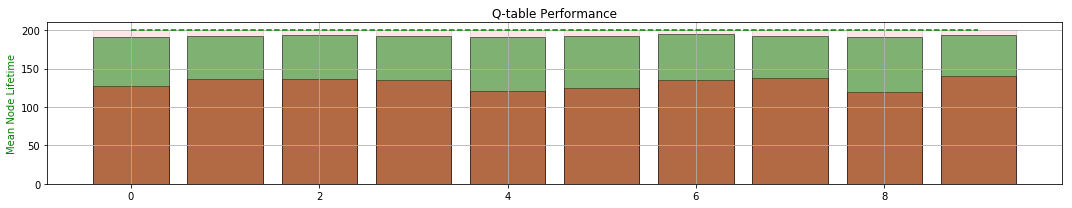

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 48.724	LOSS : 60.661	LOSS : 40.443	LOSS : 51.412	LOSS : 51.445	LOSS : 53.597	LOSS : 38.969	LOSS : 56.016	LOSS : 55.602	LOSS : 53.373	LOSS : 64.583	LOSS : 51.815	LOSS : 52.830	LOSS : 41.420	LOSS : 48.034	LOSS : 58.380	LOSS : 55.582	LOSS : 49.278	LOSS : 61.049	LOSS : 57.074	
Validating... MEAN TIME:  133.38
LOSS : 40.684	LOSS : 49.244	LOSS : 51.223	LOSS : 47.321	LOSS : 47.995	LOSS : 48.228	LOSS : 56.191	LOSS : 60.197	LOSS : 48.758	LOSS : 51.649	LOSS : 56.351	LOSS : 56.639	LOSS : 45.912	LOSS : 56.676	LOSS : 47.975	LOSS : 57.044	LOSS : 50.789	LOSS : 49.262	LOSS : 49.574	LOSS : 49.265	
Validating... MEAN TIME:  122.96
LOSS : 62.082	LOSS : 51.930	LOSS : 55.780	LOSS : 55.772	LOSS : 53.980	LOSS : 64.145	LOSS : 47.727	LOSS : 48.083	LOSS : 53.442	LOSS : 53.945	LOSS : 52.394	LOSS : 53.825	LOSS : 54.625	LOSS : 51.800	LOSS : 48.157	LOSS : 55.282	LOSS : 53.954	LOSS : 45.689	LOSS : 55.794	LOSS : 66.829	
Validat

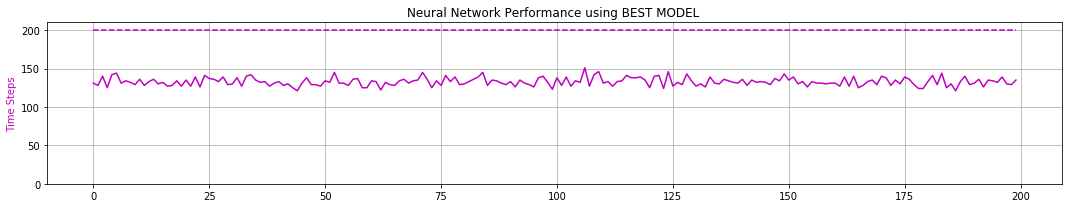

peak memory: 1489.83 MiB, increment: 977.95 MiB
0 -max- [ 1.814  2.672  0.209  2.372]
0 -min- [-2.399 -2.084 -0.169 -2.023]

1 -max- [ 1.877  2.487  0.209  2.495]
1 -min- [-2.399 -2.075 -0.206 -2.123]

2 -max- [ 1.671  2.511  0.206  2.800]
2 -min- [-2.399 -2.052 -0.199 -2.125]

3 -max- [ 2.386  2.618  0.205  2.279]
3 -min- [-2.399 -2.165 -0.165 -2.098]

4 -max- [ 1.807  2.667  0.209  2.603]
4 -min- [-2.400 -2.067 -0.200 -2.276]

5 -max- [ 1.622  2.668  0.208  2.415]
5 -min- [-2.400 -2.230 -0.209 -2.248]

6 -max- [ 2.365  2.670  0.207  2.431]
6 -min- [-2.400 -2.065 -0.164 -1.969]

7 -max- [ 1.708  2.677  0.209  2.371]
7 -min- [-2.400 -2.065 -0.209 -2.212]

8 -max- [ 1.742  2.679  0.208  2.524]
8 -min- [-2.399 -2.271 -0.192 -2.221]

9 -max- [ 1.787  2.666  0.209  2.569]
9 -min- [-2.400 -2.067 -0.197 -2.198]

Quantization TIME:  0.02 minutes


ITERATION # 34
TOTAL EXPERIENCE GENERATED:   124007
SMALLEST TIMESTEP: 93
LARGEST  TIMESTEP: 155
TOTAL SERIAL TIMESTEPS:   4380601
TOTAL PARALLEL T

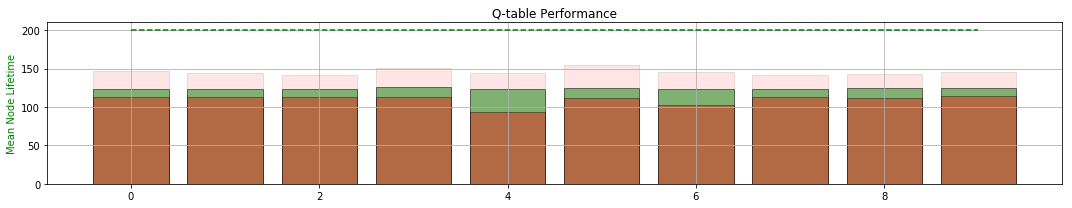

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 63.304	LOSS : 61.916	LOSS : 63.639	LOSS : 53.362	LOSS : 62.010	LOSS : 60.601	LOSS : 62.595	LOSS : 72.743	LOSS : 62.414	LOSS : 63.704	LOSS : 60.644	LOSS : 66.573	LOSS : 67.704	LOSS : 52.322	LOSS : 58.921	LOSS : 64.061	LOSS : 57.246	LOSS : 60.091	LOSS : 67.566	LOSS : 62.531	
Validating... MEAN TIME:  131.585
LOSS : 62.363	LOSS : 62.171	LOSS : 67.409	LOSS : 69.928	LOSS : 58.412	LOSS : 61.936	LOSS : 59.830	LOSS : 63.492	LOSS : 61.083	LOSS : 68.993	LOSS : 56.665	LOSS : 54.744	LOSS : 66.187	LOSS : 61.131	LOSS : 70.320	LOSS : 56.231	LOSS : 56.583	LOSS : 66.155	LOSS : 55.935	LOSS : 53.668	
Validating... MEAN TIME:  134.495
LOSS : 65.431	LOSS : 58.230	LOSS : 55.822	LOSS : 54.943	LOSS : 68.467	LOSS : 64.428	LOSS : 58.862	LOSS : 57.761	LOSS : 63.103	LOSS : 63.653	LOSS : 67.814	LOSS : 73.739	LOSS : 58.549	LOSS : 52.829	LOSS : 59.264	LOSS : 62.980	LOSS : 64.772	LOSS : 63.752	LOSS : 66.218	LOSS : 60.167	
Valid

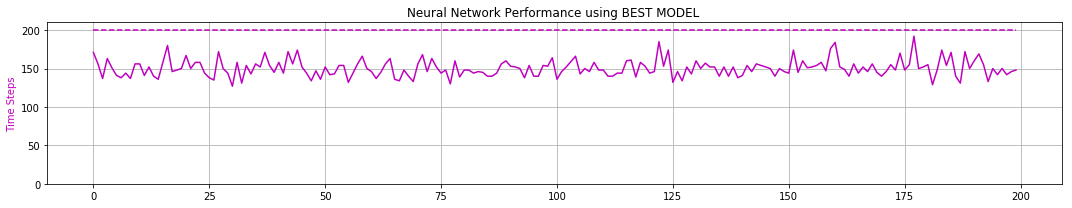

peak memory: 1509.36 MiB, increment: 978.09 MiB
0 -max- [ 0.134  1.022  0.048  0.985]
0 -min- [-2.400 -2.609 -0.206 -1.453]

1 -max- [ 0.131  1.022  0.049  1.299]
1 -min- [-2.399 -2.802 -0.193 -1.443]

2 -max- [ 0.132  0.989  0.050  0.996]
2 -min- [-2.399 -2.582 -0.205 -1.453]

3 -max- [ 0.138  1.011  0.050  1.173]
3 -min- [-2.399 -2.618 -0.195 -1.444]

4 -max- [ 0.171  1.141  0.050  1.269]
4 -min- [-2.400 -2.612 -0.207 -1.726]

5 -max- [ 0.119  1.016  0.050  0.964]
5 -min- [-2.400 -2.622 -0.193 -1.458]

6 -max- [ 0.166  1.015  0.048  1.261]
6 -min- [-2.400 -2.785 -0.208 -1.452]

7 -max- [ 0.131  1.179  0.050  1.228]
7 -min- [-2.400 -2.604 -0.206 -1.714]

8 -max- [ 0.130  1.022  0.049  1.103]
8 -min- [-2.400 -2.596 -0.193 -1.459]

9 -max- [ 0.117  1.021  0.051  1.065]
9 -min- [-2.399 -2.593 -0.193 -1.420]

Quantization TIME:  0.02 minutes


ITERATION # 35
TOTAL EXPERIENCE GENERATED:   134204
SMALLEST TIMESTEP: 114
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   4514805
TOTAL PARALLEL 

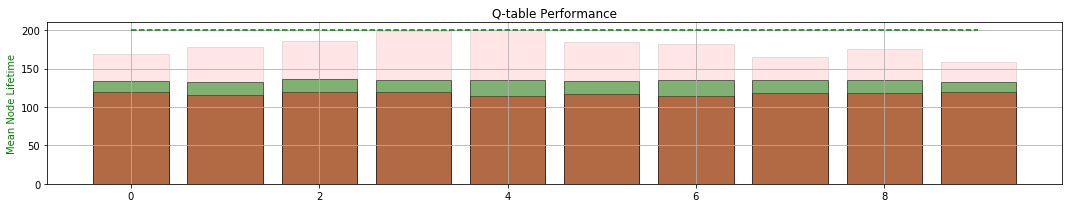

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 66.188	LOSS : 71.993	LOSS : 54.712	LOSS : 64.707	LOSS : 57.477	LOSS : 65.932	LOSS : 58.047	LOSS : 66.061	LOSS : 67.423	LOSS : 64.448	LOSS : 61.396	LOSS : 63.715	LOSS : 56.736	LOSS : 71.508	LOSS : 56.477	LOSS : 63.139	LOSS : 69.903	LOSS : 63.280	LOSS : 67.851	LOSS : 62.088	
Validating... MEAN TIME:  134.705
LOSS : 65.732	LOSS : 61.219	LOSS : 57.935	LOSS : 64.954	LOSS : 70.145	LOSS : 65.147	LOSS : 65.743	LOSS : 63.346	LOSS : 56.921	LOSS : 59.061	LOSS : 58.220	LOSS : 54.988	LOSS : 67.460	LOSS : 62.311	LOSS : 60.216	LOSS : 63.205	LOSS : 59.541	LOSS : 56.252	LOSS : 65.526	LOSS : 63.889	
Validating... MEAN TIME:  136.25
LOSS : 73.561	LOSS : 66.651	LOSS : 69.335	LOSS : 64.772	LOSS : 63.979	LOSS : 63.883	LOSS : 70.611	LOSS : 64.632	LOSS : 57.811	LOSS : 65.053	LOSS : 69.938	LOSS : 62.553	LOSS : 57.700	LOSS : 66.797	LOSS : 63.995	LOSS : 57.162	LOSS : 57.839	LOSS : 57.629	LOSS : 61.213	LOSS : 53.746	
Valida

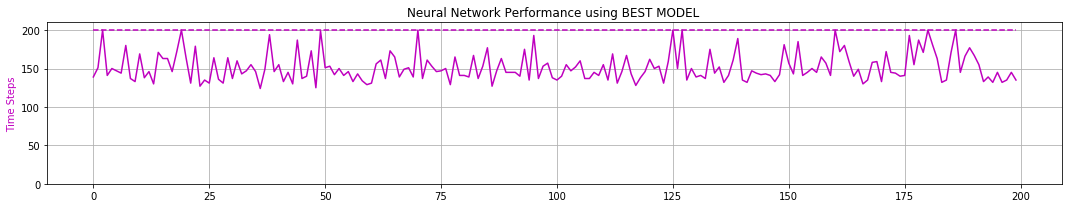

peak memory: 1453.82 MiB, increment: 996.05 MiB
0 -max- [ 0.097  0.771  0.049  0.686]
0 -min- [-2.366 -2.412 -0.209 -1.109]

1 -max- [ 0.103  0.794  0.050  0.938]
1 -min- [-2.382 -2.418 -0.209 -1.097]

2 -max- [ 0.118  0.793  0.050  0.751]
2 -min- [-2.390 -2.423 -0.209 -1.322]

3 -max- [ 0.136  0.808  0.050  0.912]
3 -min- [-2.370 -2.447 -0.209 -1.140]

4 -max- [ 0.133  0.799  0.050  1.241]
4 -min- [-2.371 -2.410 -0.209 -1.118]

5 -max- [ 0.092  0.633  0.048  1.058]
5 -min- [-2.380 -2.422 -0.209 -1.070]

6 -max- [ 0.105  0.817  0.050  0.903]
6 -min- [-2.377 -2.584 -0.209 -1.398]

7 -max- [ 0.092  0.743  0.049  1.051]
7 -min- [-2.385 -2.414 -0.209 -1.092]

8 -max- [ 0.110  0.826  0.050  0.878]
8 -min- [-2.371 -2.415 -0.209 -1.370]

9 -max- [ 0.092  0.802  0.049  0.701]
9 -min- [-2.375 -2.414 -0.209 -1.146]

Quantization TIME:  0.02 minutes


ITERATION # 36
TOTAL EXPERIENCE GENERATED:   171144
SMALLEST TIMESTEP: 115
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   4685949
TOTAL PARALLEL 

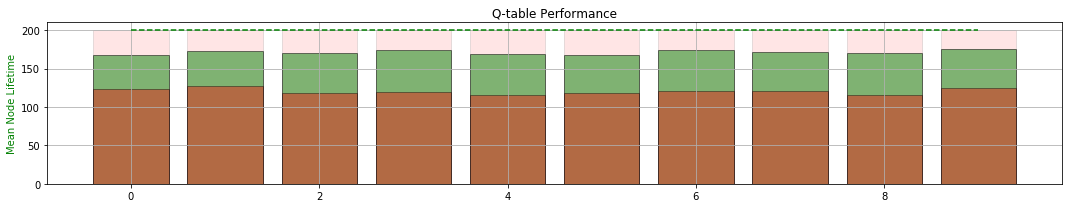

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 64.447	LOSS : 58.232	LOSS : 65.543	LOSS : 49.589	LOSS : 41.264	LOSS : 57.999	LOSS : 47.531	LOSS : 53.193	LOSS : 51.603	LOSS : 56.073	LOSS : 53.869	LOSS : 55.880	LOSS : 52.608	LOSS : 52.422	LOSS : 54.565	LOSS : 51.309	LOSS : 56.686	LOSS : 60.443	LOSS : 50.350	LOSS : 59.459	
Validating... MEAN TIME:  146.18
LOSS : 53.539	LOSS : 54.063	LOSS : 52.192	LOSS : 50.025	LOSS : 46.998	LOSS : 57.018	LOSS : 60.480	LOSS : 53.036	LOSS : 60.896	LOSS : 43.341	LOSS : 58.675	LOSS : 58.614	LOSS : 53.198	LOSS : 52.677	LOSS : 46.034	LOSS : 61.106	LOSS : 59.219	LOSS : 54.206	LOSS : 46.452	LOSS : 54.428	
Validating... MEAN TIME:  160.06
LOSS : 55.078	LOSS : 47.353	LOSS : 58.421	LOSS : 47.276	LOSS : 57.402	LOSS : 54.584	LOSS : 48.279	LOSS : 53.589	LOSS : 46.727	LOSS : 53.201	LOSS : 59.290	LOSS : 50.633	LOSS : 47.470	LOSS : 54.520	LOSS : 44.350	LOSS : 47.868	LOSS : 43.581	LOSS : 53.382	LOSS : 51.575	LOSS : 54.538	
Validat

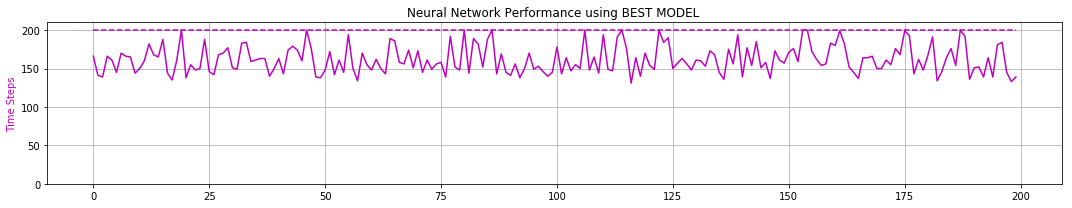

peak memory: 1492.88 MiB, increment: 978.11 MiB
0 -max- [ 2.386  1.890  0.115  1.187]
0 -min- [-2.236 -2.415 -0.209 -1.356]

1 -max- [ 2.394  1.906  0.129  1.220]
1 -min- [-2.250 -2.434 -0.209 -1.129]

2 -max- [ 2.395  2.003  0.115  1.205]
2 -min- [-2.290 -2.420 -0.209 -1.276]

3 -max- [ 2.397  1.906  0.121  1.287]
3 -min- [-2.254 -2.389 -0.209 -1.233]

4 -max- [ 2.396  2.032  0.127  1.094]
4 -min- [-2.247 -2.421 -0.209 -1.441]

5 -max- [ 2.391  2.070  0.129  1.156]
5 -min- [-2.282 -2.417 -0.208 -1.332]

6 -max- [ 2.390  1.905  0.121  1.087]
6 -min- [-2.354 -2.386 -0.209 -1.326]

7 -max- [ 2.398  2.011  0.118  1.202]
7 -min- [-2.289 -2.405 -0.209 -1.112]

8 -max- [ 2.397  1.904  0.112  1.579]
8 -min- [-2.326 -2.387 -0.209 -1.542]

9 -max- [ 2.385  1.909  0.112  1.118]
9 -min- [-2.260 -2.242 -0.209 -1.132]

Quantization TIME:  0.02 minutes


ITERATION # 37
TOTAL EXPERIENCE GENERATED:   153542
SMALLEST TIMESTEP: 117
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   4839491
TOTAL PARALLEL 

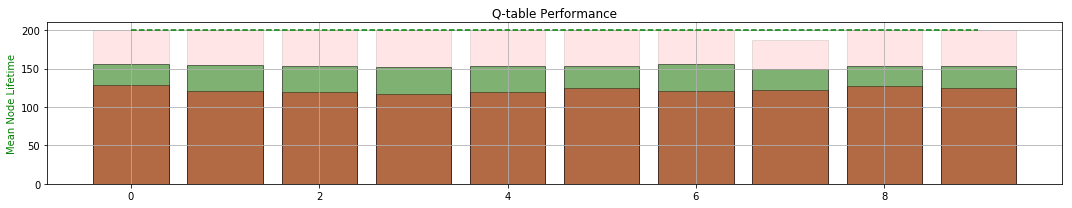

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 51.306	LOSS : 48.781	LOSS : 45.656	LOSS : 53.780	LOSS : 55.966	LOSS : 49.558	LOSS : 52.693	LOSS : 51.439	LOSS : 55.179	LOSS : 53.445	LOSS : 53.007	LOSS : 58.078	LOSS : 52.436	LOSS : 47.135	LOSS : 48.384	LOSS : 51.881	LOSS : 55.143	LOSS : 53.268	LOSS : 55.342	LOSS : 56.329	
Validating... MEAN TIME:  184.085
LOSS : 57.428	LOSS : 47.432	LOSS : 54.180	LOSS : 52.584	LOSS : 55.832	LOSS : 49.910	LOSS : 60.346	LOSS : 47.777	LOSS : 54.247	LOSS : 52.035	LOSS : 45.884	LOSS : 50.489	LOSS : 53.902	LOSS : 52.197	LOSS : 49.587	LOSS : 49.167	LOSS : 61.093	LOSS : 61.279	LOSS : 49.820	LOSS : 53.571	
Validating... MEAN TIME:  183.715
LOSS : 49.710	LOSS : 46.855	LOSS : 48.209	LOSS : 49.911	LOSS : 55.297	LOSS : 43.652	LOSS : 50.934	LOSS : 53.563	LOSS : 49.519	LOSS : 53.774	LOSS : 50.907	LOSS : 63.738	LOSS : 51.173	LOSS : 53.011	LOSS : 55.410	LOSS : 48.829	LOSS : 51.161	LOSS : 45.450	LOSS : 55.288	LOSS : 46.194	
Valid

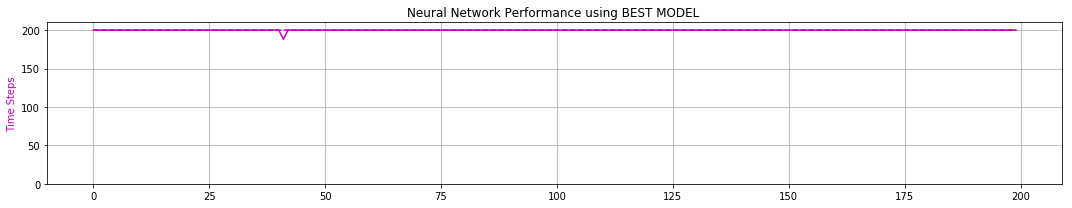

peak memory: 1510.81 MiB, increment: 1015.44 MiB
0 -max- [ 2.399  1.917  0.108  0.964]
0 -min- [-2.137 -2.154 -0.209 -1.223]

1 -max- [ 2.378  1.910  0.094  1.012]
1 -min- [-2.135 -2.229 -0.209 -1.428]

2 -max- [ 2.391  1.909  0.103  0.956]
2 -min- [-2.160 -2.218 -0.209 -1.097]

3 -max- [ 2.396  1.897  0.119  1.014]
3 -min- [-2.161 -2.174 -0.209 -1.107]

4 -max- [ 2.395  1.921  0.105  1.026]
4 -min- [-2.176 -2.158 -0.209 -1.217]

5 -max- [ 2.195  1.865  0.095  1.005]
5 -min- [-2.123 -2.235 -0.209 -1.207]

6 -max- [ 2.393  2.094  0.110  1.305]
6 -min- [-2.159 -2.142 -0.209 -1.323]

7 -max- [ 0.077  0.634  0.049  0.868]
7 -min- [-2.146 -2.134 -0.209 -1.094]

8 -max- [ 2.398  1.903  0.097  0.976]
8 -min- [-2.153 -2.170 -0.209 -1.196]

9 -max- [ 2.386  1.907  0.097  0.992]
9 -min- [-2.192 -2.145 -0.209 -1.185]

Quantization TIME:  0.02 minutes


ITERATION # 38
TOTAL EXPERIENCE GENERATED:   181078
SMALLEST TIMESTEP: 148
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   5020569
TOTAL PARALLEL

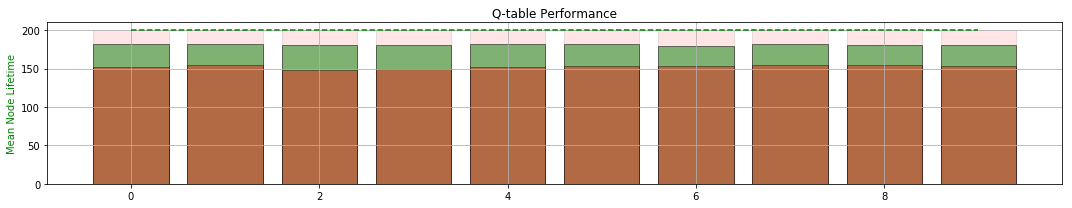

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 70.786	LOSS : 57.511	LOSS : 56.520	LOSS : 56.129	LOSS : 56.497	LOSS : 55.793	LOSS : 53.874	LOSS : 53.496	LOSS : 52.586	LOSS : 57.980	LOSS : 51.709	LOSS : 47.132	LOSS : 51.554	LOSS : 48.653	LOSS : 52.259	LOSS : 59.936	LOSS : 48.970	LOSS : 52.098	LOSS : 52.920	LOSS : 50.035	
Validating... MEAN TIME:  169.775
LOSS : 52.198	LOSS : 53.744	LOSS : 48.007	LOSS : 55.320	LOSS : 44.288	LOSS : 58.212	LOSS : 50.313	LOSS : 39.533	LOSS : 52.636	LOSS : 42.408	LOSS : 54.025	LOSS : 54.476	LOSS : 51.792	LOSS : 55.156	LOSS : 53.094	LOSS : 44.153	LOSS : 53.525	LOSS : 47.345	LOSS : 41.375	LOSS : 52.859	
Validating... MEAN TIME:  185.72
LOSS : 49.856	LOSS : 60.598	LOSS : 52.862	LOSS : 42.318	LOSS : 47.956	LOSS : 54.141	LOSS : 53.185	LOSS : 45.627	LOSS : 48.119	LOSS : 57.261	LOSS : 50.828	LOSS : 49.359	LOSS : 50.411	LOSS : 50.992	LOSS : 51.201	LOSS : 47.579	LOSS : 48.732	LOSS : 50.793	LOSS : 53.070	LOSS : 56.283	
Valida

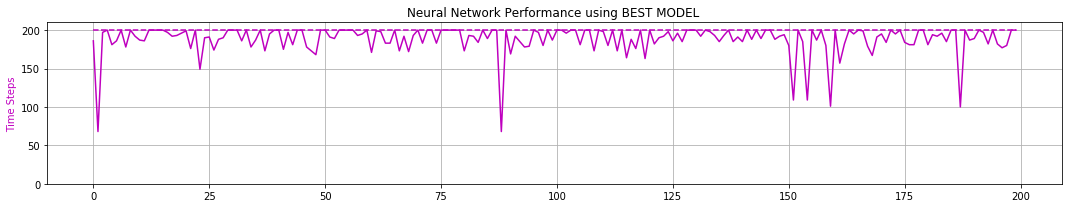

peak memory: 1502.68 MiB, increment: 1074.09 MiB
0 -max- [ 2.395  1.714  0.098  1.204]
0 -min- [-2.400 -1.878 -0.196 -1.122]

1 -max- [ 2.395  1.714  0.099  0.743]
1 -min- [-2.400 -1.703 -0.139 -0.952]

2 -max- [ 2.386  1.699  0.099  0.754]
2 -min- [-2.400 -1.716 -0.126 -0.950]

3 -max- [ 2.399  1.714  0.097  0.975]
3 -min- [-2.400 -1.828 -0.163 -1.054]

4 -max- [ 2.399  1.716  0.097  0.972]
4 -min- [-2.400 -1.824 -0.139 -1.064]

5 -max- [ 2.397  1.718  0.096  0.997]
5 -min- [-2.400 -1.881 -0.125 -0.949]

6 -max- [ 2.166  1.485  0.093  0.738]
6 -min- [-2.400 -1.699 -0.131 -0.945]

7 -max- [ 2.394  1.712  0.097  0.744]
7 -min- [-2.400 -1.709 -0.128 -0.965]

8 -max- [ 2.386  1.714  0.096  0.997]
8 -min- [-2.400 -1.864 -0.137 -1.055]

9 -max- [ 2.396  1.716  0.102  0.742]
9 -min- [-2.399 -1.718 -0.133 -0.984]

Quantization TIME:  0.01 minutes


ITERATION # 39
TOTAL EXPERIENCE GENERATED:   170186
SMALLEST TIMESTEP: 20
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   5190755
TOTAL PARALLEL 

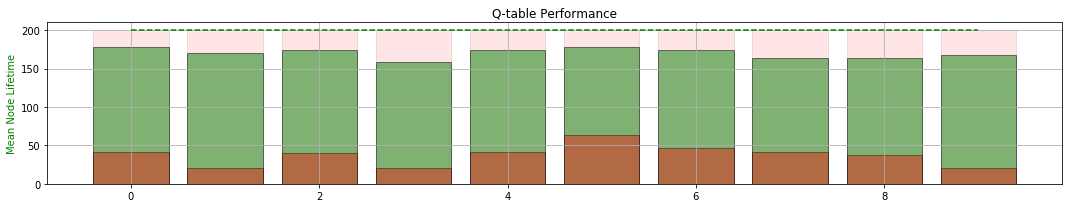

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 60.845	LOSS : 49.430	LOSS : 61.895	LOSS : 61.187	LOSS : 45.598	LOSS : 51.655	LOSS : 60.176	LOSS : 58.090	LOSS : 56.501	LOSS : 65.478	LOSS : 52.785	LOSS : 53.428	LOSS : 52.363	LOSS : 56.812	LOSS : 55.448	LOSS : 56.929	LOSS : 54.550	LOSS : 57.327	LOSS : 48.226	LOSS : 59.902	
Validating... MEAN TIME:  149.985
LOSS : 50.489	LOSS : 58.372	LOSS : 55.113	LOSS : 58.673	LOSS : 71.246	LOSS : 59.011	LOSS : 61.616	LOSS : 56.361	LOSS : 57.469	LOSS : 61.949	LOSS : 65.188	LOSS : 59.916	LOSS : 45.747	LOSS : 56.909	LOSS : 56.488	LOSS : 64.913	LOSS : 60.241	LOSS : 55.801	LOSS : 53.029	LOSS : 51.910	
Validating... MEAN TIME:  197.04
LOSS : 52.779	LOSS : 67.227	LOSS : 69.774	LOSS : 68.645	LOSS : 53.330	LOSS : 68.014	LOSS : 60.650	LOSS : 58.591	LOSS : 58.137	LOSS : 62.889	LOSS : 51.738	LOSS : 59.479	LOSS : 46.151	LOSS : 63.407	LOSS : 50.519	LOSS : 53.617	LOSS : 54.660	LOSS : 54.297	LOSS : 62.071	LOSS : 61.505	
Valida

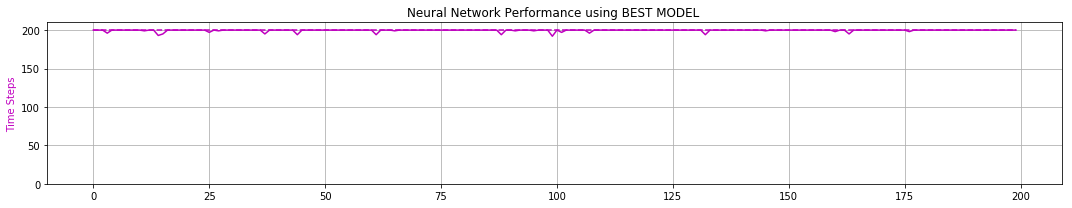

peak memory: 1483.88 MiB, increment: 1025.78 MiB
0 -max- [ 2.398  2.243  0.209  2.372]
0 -min- [-2.398 -2.016 -0.208 -2.289]

1 -max- [ 2.399  2.659  0.209  2.320]
1 -min- [-2.397 -1.978 -0.209 -2.237]

2 -max- [ 2.398  2.458  0.209  2.260]
2 -min- [-2.398 -2.065 -0.208 -2.283]

3 -max- [ 2.400  2.212  0.208  2.326]
3 -min- [-2.398 -2.075 -0.209 -2.270]

4 -max- [ 2.400  2.632  0.209  2.281]
4 -min- [-2.397 -2.006 -0.209 -2.265]

5 -max- [ 2.397  2.659  0.209  2.256]
5 -min- [-2.399 -2.424 -0.208 -2.139]

6 -max- [ 2.398  2.624  0.209  2.256]
6 -min- [-2.395 -1.904 -0.209 -2.162]

7 -max- [ 2.399  2.486  0.209  2.398]
7 -min- [-2.400 -2.010 -0.209 -2.281]

8 -max- [ 2.398  2.436  0.209  2.553]
8 -min- [-2.400 -2.059 -0.208 -2.192]

9 -max- [ 2.399  2.656  0.209  2.581]
9 -min- [-2.400 -2.252 -0.206 -2.283]

Quantization TIME:  0.01 minutes


ITERATION # 40
TOTAL EXPERIENCE GENERATED:   158567
SMALLEST TIMESTEP: 137
LARGEST  TIMESTEP: 195
TOTAL SERIAL TIMESTEPS:   5349322
TOTAL PARALLEL

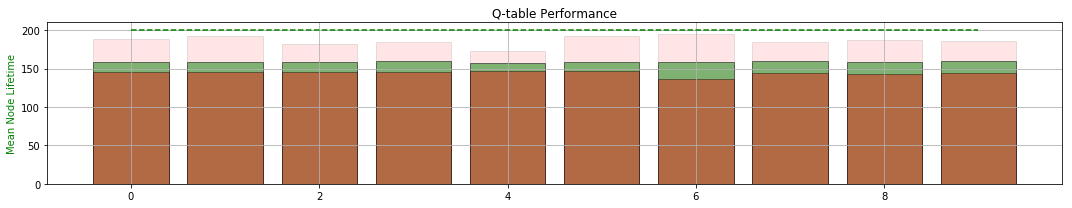

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 48.128	LOSS : 56.874	LOSS : 57.004	LOSS : 57.431	LOSS : 54.034	LOSS : 52.243	LOSS : 51.437	LOSS : 49.810	LOSS : 50.037	LOSS : 55.112	LOSS : 47.271	LOSS : 49.671	LOSS : 53.915	LOSS : 57.331	LOSS : 49.384	LOSS : 48.578	LOSS : 48.998	LOSS : 48.755	LOSS : 52.336	LOSS : 45.124	
Validating... MEAN TIME:  183.54
LOSS : 51.670	LOSS : 51.499	LOSS : 51.970	LOSS : 53.415	LOSS : 47.728	LOSS : 56.198	LOSS : 56.217	LOSS : 49.945	LOSS : 50.611	LOSS : 55.444	LOSS : 48.129	LOSS : 49.288	LOSS : 45.489	LOSS : 54.540	LOSS : 50.718	LOSS : 49.797	LOSS : 49.067	LOSS : 54.802	LOSS : 50.978	LOSS : 42.870	
Validating... MEAN TIME:  196.835
LOSS : 54.239	LOSS : 53.787	LOSS : 49.488	LOSS : 59.516	LOSS : 54.724	LOSS : 50.359	LOSS : 51.601	LOSS : 54.928	LOSS : 54.125	LOSS : 51.285	LOSS : 44.440	LOSS : 51.772	LOSS : 53.212	LOSS : 60.549	LOSS : 54.676	LOSS : 48.473	LOSS : 46.530	LOSS : 49.919	LOSS : 55.315	LOSS : 56.435	
Valida

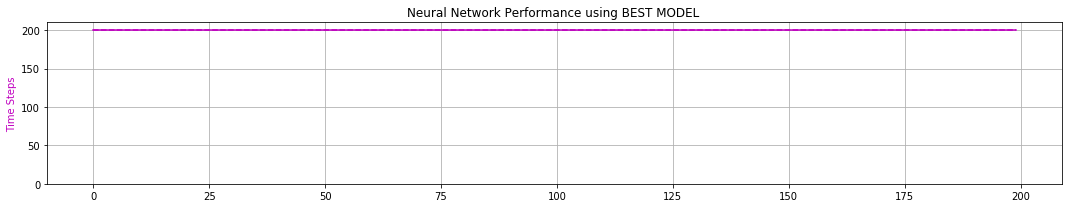

peak memory: 1483.87 MiB, increment: 977.88 MiB
0 -max- [ 0.111  0.820  0.048  1.027]
0 -min- [-2.399 -1.881 -0.203 -1.183]

1 -max- [ 0.105  0.824  0.050  1.292]
1 -min- [-2.399 -2.067 -0.195 -1.214]

2 -max- [ 0.108  0.827  0.049  1.110]
2 -min- [-2.400 -1.893 -0.202 -1.211]

3 -max- [ 0.130  1.013  0.050  1.224]
3 -min- [-2.400 -1.896 -0.200 -1.364]

4 -max- [ 0.097  0.829  0.049  1.024]
4 -min- [-2.400 -1.870 -0.204 -1.194]

5 -max- [ 0.116  0.827  0.049  0.949]
5 -min- [-2.400 -1.873 -0.202 -1.183]

6 -max- [ 0.164  0.976  0.047  1.504]
6 -min- [-2.400 -1.906 -0.209 -1.469]

7 -max- [ 0.142  1.014  0.051  1.107]
7 -min- [-2.400 -1.912 -0.206 -1.361]

8 -max- [ 0.110  0.823  0.047  1.103]
8 -min- [-2.400 -1.875 -0.198 -1.191]

9 -max- [ 0.122  1.022  0.050  1.033]
9 -min- [-2.399 -1.907 -0.209 -1.366]

Quantization TIME:  0.01 minutes


ITERATION # 41
TOTAL EXPERIENCE GENERATED:   167103
SMALLEST TIMESTEP: 146
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   5516425
TOTAL PARALLEL 

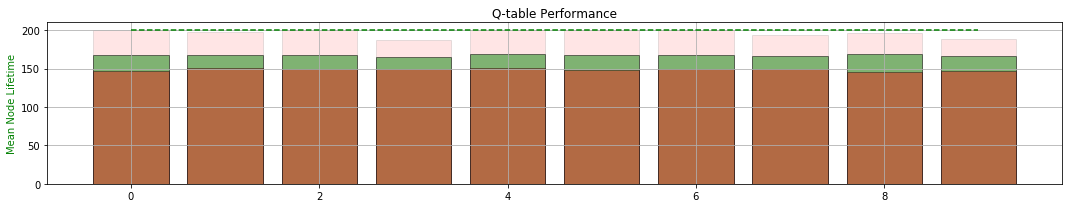

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 49.415	LOSS : 48.480	LOSS : 44.436	LOSS : 59.957	LOSS : 53.101	LOSS : 45.026	LOSS : 45.376	LOSS : 44.399	LOSS : 49.884	LOSS : 51.420	LOSS : 42.257	LOSS : 50.974	LOSS : 47.270	LOSS : 44.479	LOSS : 53.526	LOSS : 50.106	LOSS : 46.569	LOSS : 50.886	LOSS : 48.308	LOSS : 59.859	
Validating... MEAN TIME:  189.675
LOSS : 49.871	LOSS : 52.363	LOSS : 47.856	LOSS : 52.019	LOSS : 40.446	LOSS : 44.539	LOSS : 51.466	LOSS : 47.942	LOSS : 50.803	LOSS : 46.309	LOSS : 57.610	LOSS : 48.107	LOSS : 43.158	LOSS : 51.638	LOSS : 50.168	LOSS : 44.082	LOSS : 53.057	LOSS : 53.291	LOSS : 47.107	LOSS : 45.473	
Validating... MEAN TIME:  199.985
LOSS : 47.279	LOSS : 45.421	LOSS : 50.784	LOSS : 51.537	LOSS : 52.020	LOSS : 44.736	LOSS : 52.302	LOSS : 46.382	LOSS : 51.054	LOSS : 58.349	LOSS : 51.825	LOSS : 51.290	LOSS : 44.907	LOSS : 42.896	LOSS : 43.361	LOSS : 46.046	LOSS : 53.467	LOSS : 49.695	LOSS : 41.124	LOSS : 42.996	
Valid

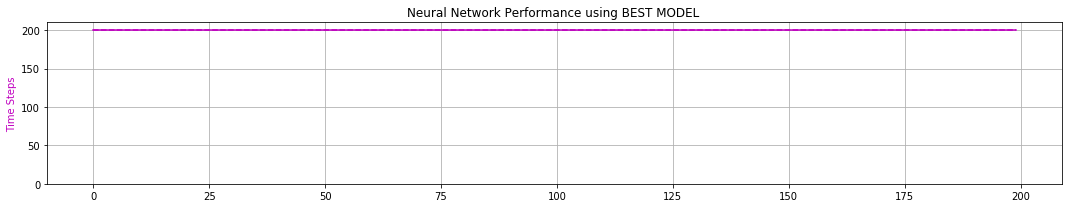

peak memory: 1476.48 MiB, increment: 1036.12 MiB
0 -max- [ 0.105  0.983  0.053  1.297]
0 -min- [-2.400 -2.164 -0.186 -1.468]

1 -max- [ 0.108  0.962  0.049  0.996]
1 -min- [-2.400 -2.163 -0.184 -1.397]

2 -max- [ 0.115  1.013  0.050  1.260]
2 -min- [-2.400 -2.158 -0.182 -1.364]

3 -max- [ 0.105  0.969  0.049  1.276]
3 -min- [-2.400 -2.040 -0.180 -1.386]

4 -max- [ 0.116  0.827  0.049  1.158]
4 -min- [-2.400 -2.151 -0.180 -1.297]

5 -max- [ 0.118  0.823  0.047  1.116]
5 -min- [-2.400 -2.179 -0.187 -1.182]

6 -max- [ 0.142  1.014  0.051  1.290]
6 -min- [-2.400 -2.152 -0.200 -1.361]

7 -max- [ 0.110  0.827  0.051  1.131]
7 -min- [-2.400 -2.041 -0.189 -1.191]

8 -max- [ 0.122  1.022  0.050  1.168]
8 -min- [-2.400 -2.158 -0.190 -1.366]

9 -max- [ 0.106  0.964  0.050  1.298]
9 -min- [-2.400 -2.195 -0.182 -1.358]

Quantization TIME:  0.02 minutes


ITERATION # 42
TOTAL EXPERIENCE GENERATED:   151606
SMALLEST TIMESTEP: 138
LARGEST  TIMESTEP: 168
TOTAL SERIAL TIMESTEPS:   5668031
TOTAL PARALLEL

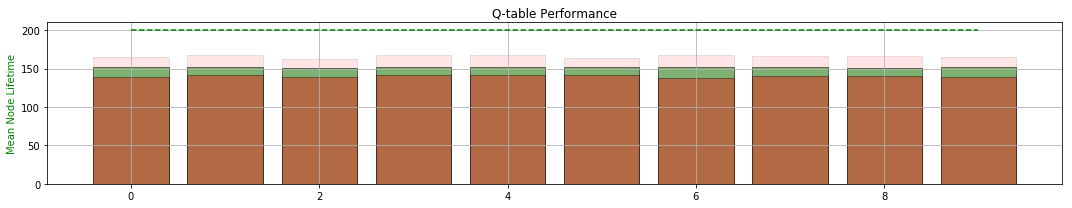

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 63.817	LOSS : 52.654	LOSS : 56.320	LOSS : 56.194	LOSS : 59.438	LOSS : 64.269	LOSS : 66.326	LOSS : 58.780	LOSS : 51.046	LOSS : 57.397	LOSS : 51.738	LOSS : 59.349	LOSS : 46.567	LOSS : 59.101	LOSS : 48.658	LOSS : 55.615	LOSS : 59.129	LOSS : 56.812	LOSS : 64.036	LOSS : 58.011	
Validating... MEAN TIME:  152.745
LOSS : 62.108	LOSS : 63.676	LOSS : 55.672	LOSS : 56.688	LOSS : 56.001	LOSS : 66.884	LOSS : 56.164	LOSS : 49.330	LOSS : 53.326	LOSS : 54.194	LOSS : 59.227	LOSS : 66.229	LOSS : 55.545	LOSS : 56.808	LOSS : 58.110	LOSS : 58.469	LOSS : 56.776	LOSS : 60.532	LOSS : 59.750	LOSS : 54.682	
Validating... MEAN TIME:  156.36
LOSS : 50.992	LOSS : 59.728	LOSS : 65.781	LOSS : 54.642	LOSS : 60.424	LOSS : 63.532	LOSS : 59.019	LOSS : 65.864	LOSS : 59.632	LOSS : 53.963	LOSS : 46.019	LOSS : 59.656	LOSS : 63.127	LOSS : 51.247	LOSS : 60.706	LOSS : 62.790	LOSS : 57.220	LOSS : 50.069	LOSS : 57.776	LOSS : 64.884	
Valida

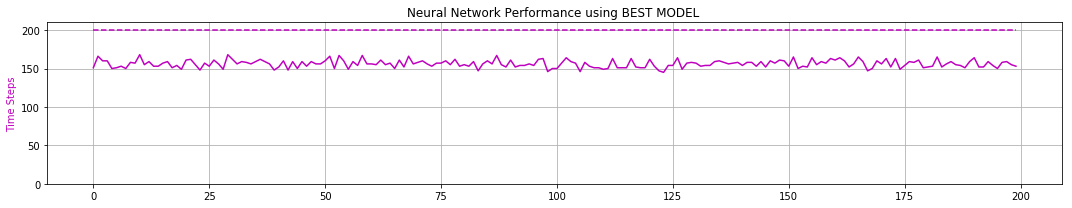

peak memory: 1476.64 MiB, increment: 977.69 MiB
0 -max- [ 0.132  0.827  0.062  0.956]
0 -min- [-2.400 -1.716 -0.156 -1.249]

1 -max- [ 0.143  1.013  0.066  0.968]
1 -min- [-2.400 -1.726 -0.139 -1.364]

2 -max- [ 0.110  0.829  0.061  0.839]
2 -min- [-2.400 -1.692 -0.134 -1.194]

3 -max- [ 0.146  0.827  0.050  0.950]
3 -min- [-2.400 -1.667 -0.143 -1.228]

4 -max- [ 0.148  0.823  0.074  0.984]
4 -min- [-2.400 -1.685 -0.154 -1.192]

5 -max- [ 0.163  1.014  0.078  1.046]
5 -min- [-2.400 -1.838 -0.145 -1.361]

6 -max- [ 0.136  0.827  0.072  1.011]
6 -min- [-2.400 -1.848 -0.144 -1.191]

7 -max- [ 0.141  1.022  0.053  0.967]
7 -min- [-2.400 -1.672 -0.142 -1.366]

8 -max- [ 0.122  0.992  0.062  1.155]
8 -min- [-2.400 -1.680 -0.179 -1.507]

9 -max- [ 0.126  0.829  0.052  0.994]
9 -min- [-2.400 -1.835 -0.135 -1.183]

Quantization TIME:  0.02 minutes


ITERATION # 43
TOTAL EXPERIENCE GENERATED:   125780
SMALLEST TIMESTEP: 13
LARGEST  TIMESTEP: 140
TOTAL SERIAL TIMESTEPS:   5793811
TOTAL PARALLEL T

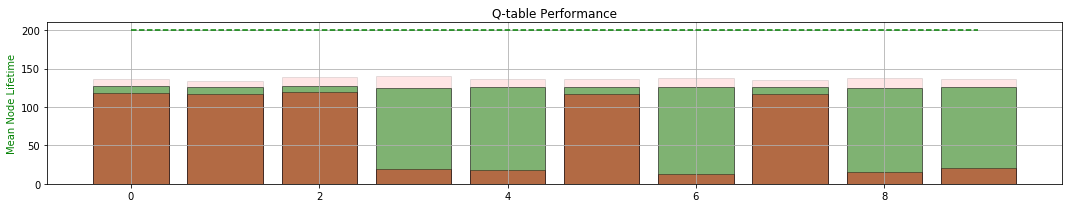

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.0001
LOSS : 62.801	LOSS : 70.804	LOSS : 65.814	LOSS : 49.990	LOSS : 50.150	LOSS : 61.426	LOSS : 66.273	LOSS : 66.562	LOSS : 76.961	LOSS : 56.076	LOSS : 55.964	LOSS : 69.273	LOSS : 63.585	LOSS : 67.253	LOSS : 65.331	LOSS : 59.781	LOSS : 60.896	LOSS : 67.106	LOSS : 68.535	LOSS : 59.895	
Validating... MEAN TIME:  154.235
LOSS : 63.553	LOSS : 67.642	LOSS : 58.195	LOSS : 57.063	LOSS : 66.481	LOSS : 67.600	LOSS : 65.172	LOSS : 67.562	LOSS : 67.461	LOSS : 69.375	LOSS : 58.856	LOSS : 58.145	LOSS : 64.792	LOSS : 59.335	LOSS : 69.929	LOSS : 61.362	LOSS : 64.857	LOSS : 57.978	LOSS : 67.037	LOSS : 58.644	
Validating... MEAN TIME:  191.08
LOSS : 57.088	LOSS : 66.569	LOSS : 63.780	LOSS : 65.099	LOSS : 60.408	LOSS : 70.057	LOSS : 67.430	LOSS : 71.542	LOSS : 63.051	LOSS : 65.082	LOSS : 73.396	LOSS : 68.771	LOSS : 56.265	LOSS : 70.211	LOSS : 71.189	LOSS : 64.990	LOSS : 57.462	LOSS : 57.808	LOSS : 59.028	LOSS : 54.223	
Valida

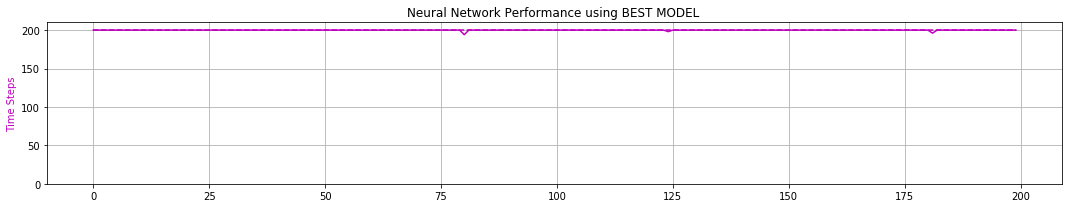

peak memory: 1484.59 MiB, increment: 1005.05 MiB
0 -max- [ 0.178  1.013  0.055  1.113]
0 -min- [-2.400 -2.081 -0.186 -1.364]

1 -max- [ 0.144  0.829  0.058  1.277]
1 -min- [-2.400 -2.183 -0.186 -1.219]

2 -max- [ 0.174  0.829  0.067  1.220]
2 -min- [-2.400 -2.181 -0.186 -1.225]

3 -max- [ 0.185  0.985  0.066  1.272]
3 -min- [-2.400 -2.197 -0.202 -1.416]

4 -max- [ 0.182  1.021  0.064  1.131]
4 -min- [-2.400 -1.986 -0.206 -1.424]

5 -max- [ 0.173  1.013  0.055  1.271]
5 -min- [-2.400 -2.180 -0.198 -1.445]

6 -max- [ 0.177  1.022  0.054  1.176]
6 -min- [-2.400 -2.180 -0.204 -1.366]

7 -max- [ 0.160  0.964  0.083  1.260]
7 -min- [-2.399 -2.196 -0.201 -1.358]

8 -max- [ 0.156  0.828  0.062  1.532]
8 -min- [-2.400 -2.182 -0.209 -1.257]

9 -max- [ 0.175  1.004  0.056  1.216]
9 -min- [-2.400 -2.182 -0.198 -1.447]

Quantization TIME:  0.01 minutes


ITERATION # 44
TOTAL EXPERIENCE GENERATED:   199897
SMALLEST TIMESTEP: 97
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   5993708
TOTAL PARALLEL 

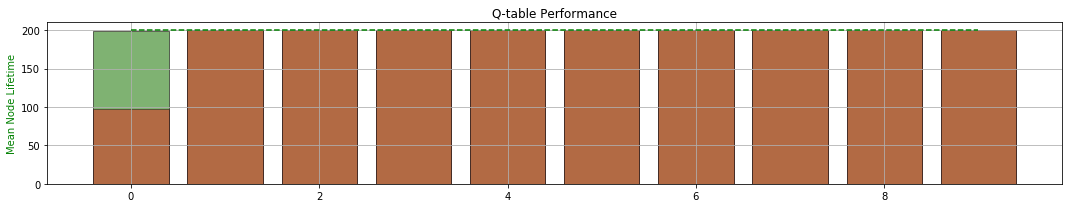

In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    q_table_list = [node_q_table]* NO_OF_NODES
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)
    
    print("TOTAL EXPERIENCE GENERATED:   {:d}".format(EXP_GEN.astype(int)))

    print("SMALLEST TIMESTEP: {:d}".format(node_time_rec.min().astype(int)))
    print("LARGEST  TIMESTEP: {:d}".format(node_time_rec.max().astype(int)))

    print("TOTAL SERIAL TIMESTEPS:   {:d}".format(total_serial_timesteps.astype(int)))
    print("TOTAL PARALLEL TIMESTEPS: {:d}".format(total_parallel_timesteps.astype(int)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_avg_time[node_avg_time >= 195].shape[0] > NO_OF_NODES/2:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                nn_level_up_metric = clamp(0, nn_level_up_metric, 195)
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        time_step = 0
        s = env.reset()

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        
    ##################################################################
    
    # CREATE ONE LARGE Q-TABLES FROM WHICH THE NODES STRIP
    ##################################################################
        
#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN * NO_OF_NODES  ])
    
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)

    # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
    stop = timeit.default_timer()

#     ##################################################################
    
#     # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
#     ##################################################################
    
    for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
# #         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
# #                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
# #         # CREATE STATE COMBINATIONS
# #         ###############################################

#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################
#     start = timeit.default_timer()
#     # GET Q-VALUES 
#     %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#     # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  8180.0
Total Serial Timesteps   :  5993708.0
Speed-up                 :  732.73


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

  9295 SUCCESS  97  44    8180    5993708     732.73
